In [1]:
run statistic.ipynb

('a', 1)
['adfkj']


<Figure size 640x480 with 60 Axes>

In [2]:
run io.ipynb

['b', 'c']
['b', 'c']
False
['a', 'b', 'c']
a
False

[[1 2]
 [3 4]]
[[1 2]
 [3 4]
 [5 6]]
001


('a', 1)
['adfkj']


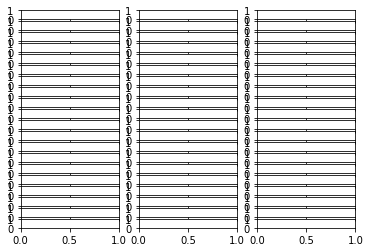

[0 1 0]


In [3]:
run data_anal.ipynb

In [7]:
# Wrapper of ML kernals for hadron correlators on lattice
import sys
import os
import datetime
import numpy as np
import yaml as yl
import sklearn.ensemble as sle
import sklearn.tree as slt
import matplotlib.pyplot as plot
import math
from itertools import product

RandTrn = []
RandBC = []
RandUnl = []

noSaveRand = True

# Algorithm depend. params
TOL = 1.0e-4
MIN_SSPLIT = 2
# Minimum #fits
MIN_FIT = 1
# Minimum #training data
MIN_TRAIN = 10
# Minimum #bias correction (bc) data
MIN_BC = 10
# Minimum #unlabeled data
MIN_PREDICT = 10
PRINT = False
SHOW = True

# Class to ML fits 
#   pfile: parameter file
class ML_Regression:
    def __init__(self, pfile, RandTrn=[], RandBC=[], RandUnl=[]):
        params = yl.load(pfile)
        # model list: GradiantBoost, DecisionTree, RandomForest, DeepLearning(using Keras)
        self.mllist = ['GB', 'DT', 'RF', 'DL']
        # pick training data set: Jackknife, Bootstrap, Random, k-fold-CrossValidation
        self.tdlist = ['JK', 'BS', 'RM', 'CV', 'CV1']
        self.form = params['format']
        try:
            self.estimator = params['estimate']
            self.rate = params['rate']
        except:
            self.estimator = None
            self.rate = None
        try:
            self.rmseed = params['rmseed']
        except:
            self.rmseed = 2018
        #np.random.seed(self.rmseed)
        try:
            self.fixRM = params['fixRM']
        except:
            self.fixRM = False
            #self.rmseed = None
        #self.dfile = params['dfile']
        # method to pick training data set: default to pick first self.trn data
        self.nfit = MIN_FIT
        self.print = PRINT
        self.pre_anly = True
        self.fitter_DL = None
        try:
            self.pred = params['pred']
        except:
            self.pred = True
        self.incbc = True
        try:
            self.tdset = params['tdset']
            #print(self.tdset)
            if self.tdset in self.tdlist:
                try:
                    self.nfit = params['nfit']
                except:
                    self.nfit = MIN_FIT
                if self.tdset == 'JK':
                    # Jackknife index
                    try:
                        self.itdpar = params['tdpar']
                    except:
                        self.itdpar = 0
                    self.tdpar = self.itdpar-1
                    self.jk = False
                if self.tdset == 'BS':
                    self.nfit += 1
                    self.bs = False
                    try:
                        self.fixbs = params['fixRM']
                    except:
                        self.fixbs = False
                    if self.fixbs: 
                        self.Rtrn = RandTrn
                        self.Rbc = RandBC
                        self.Runl = RandUnl
                # k-fold Cross-validation: 5 <= k <= 10
                if 'CV' in self.tdset:
                    if self.nfit > 10:
                        self.nfit = 10
                    #if self.nfit < 5:
                    #    self.nfit = 5
                    self.nfit += 1
                    try:
                        self.incbc = params['includeBC']
                    except:
                        self.incbc = False
                    self.cv = False
                    try:
                        self.fixcv = params['fixRM']
                    except:
                        self.fixcv = False
                    if self.fixcv:
                        self.Rm = RandTrn
            elif not isinstance(self.tdset, int):
                print('Warning: Unknown training data subset identifier! Set to 0\n')
                self.tdset = 0
        except:
            self.tdset = 0
        print(self.tdset)
        try:
            self.odir = params['odir']
            self.osave = True
        except:
            self.osave = False
            self.ofile = None
        self.pdir = params['pdir']
        self.mlml = params['mlml']
        pdfile = open(self.pdir+'/'+self.mlml,'r')
        self.pf = yl.load(pdfile)
        pdfile.close()
        try:
            self.anal = params['analysis']
        except:
            self.anal = False
        self.effmass = False
        self.ratio = False
        self.save_tmpfits = False
        self.panal = False
        if self.anal: 
            if self.form == 'pdf':
                self.panal = True
                self.post_anal = ML_Analyze_PDF(params)
                self.save_tmpfits = True
            try:
                self.effmass = params['effmass']
            except:
                self.effmass = False
            try:
                self.ratio = params['ratio']
            except:
                self.ratio = False
        # list of Y momentum
        self.prY = params['momentum_Y']
        # list of Y z's
        self.zrY = params['z_Y']
        try:
            self.prX = params['momentum_X']
            if len(list(self.prX)) == 0:
                self.prX = None
        except:
            self.prX = None
        try:
            self.zrX = params['z_X']
            if len(list(self.zrX)) == 0:
                self.zrX = None
        except:
            self.zrX = None
        try:
            self.orY = params['operator_Y']
            if len(list(self.orY))==0:
                self.orY = [None]
        except:
            self.orY = [None]
        try:
            self.orX = params['operator_X']
            if len(list(self.orX))==0:
                self.orX = [None]
        except:
            self.orX = [None]
        try:
            self.srY = params['T_Y']
        except:
            self.srY = [None]
        try:
            self.srX = params['T_X']
        except:
            self.srX = [None]
        # list of Y time slices
        try:
            self.tr = params['ts_Y']
            if self.tr is None:
                self.tr = [None]
            elif len(list(self.tr)) == 0:
                self.tr = [None]
        except: 
            self.tr = [None]
        # list of X & Y time differences
        self.dtr = params['dts_X']
        # number of sources per configuration
        try:
            self.tfold = params['nsrc']
        except:
            self.tfold = 0
        self.ntrn = params['ntrn']
        if isinstance(self.ntrn, (int, str)):
            assert(int(self.ntrn) >= MIN_TRAIN)
            self.ntrn = [int(self.ntrn)]
        else:
            assert(len(self.ntrn) == len(self.prX))
        self.nbc = params['nbc']
        if isinstance(self.nbc, (int, str)):
            assert(int(self.nbc) >= MIN_BC)
            self.nbc = [int(self.nbc)]
        else:
            assert(len(self.nbc) == len(self.prX))
        # read in data stored in data pool 'database'
        # params[]: 
        #     format (data format, 'raw','pdf'); 
        #     binsize (data bin); 
        #     ddir (data files directory)
        #     dfile.x (X data filename); 
        #     dfile.y (Y data filename);
        print("Reading data...\n")
        self.database = Data_IO(params, self.tdset)
        print("Done reading data\n")
        self.data = None
        self.ndata = 0
        self.model = None
        self.fitnow = None
        self.isset = False
        self.errscale = None
        self.date = self.database.date #datetime.datetime.today().strftime('%m%d%Y')
        # Data IO, moved to the io kernel 
        return
    
    # clear data, free memory
    def finalize(self): 
        if self.panal: 
            self.post_anal.finalize()
        self.cleanup_data()
        self.del_data()
        self.database.finalize()
        if (self.tdset == 'BS') and (self.fixbs is True):
            del self.Rtrn
            del self.Rbc
            del self.Runl
            self.Rtrn = None
            self.Rbc = None
            self.Runl = None
        if 'CV' in self.tdset:
            del self.Rm
            self.Rm = None
        return
        
    # Initialize fits
    # Select correlator characters, p (momentum), z (Wilson link lenght), t (sink time slice), etc., 
    #        data sets, and assign the fit model
    def inifit(self, fdparX, fdparY, indx):
        print("Initfit...\n")
        self.ftag = None
        self.dtag = None
        self.p = None
        self.c = None
        self.y = None
        if self.del_data: 
            self.data = {}
            self.add2pt = False
            if self.ratio:
                #print("Y tags are {:}".format(fdparY))
                deltagY, self.ftag, self.spectag, self.data['Y'], self.data['S'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = len(self.spectag)
                self.add2pt = (self.n2pt > 0)
            else:
                deltagY, self.ftag, self.data['Y'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = 0
            if self.data['Y'].shape[0]==0:
                self.ny=0
                self.nx=0
                self.fitnow = self.nfit
                return
            self.dtX, self.dtag, self.data['X'], self.dmeanX, self.dstdX = self.database.select_data(fdparX, 'X')       
        #print("self.data['X'] is {:}".format(self.data['X']))
        self.ndata = self.data['X'].shape[0]
        if self.ndata > self.data['Y'].shape[0]:
            self.ndata = self.data['Y'].shape[0]
        if 'CV' in self.tdset:
            self.mlscr = []
            self.mlscr0 = []
            self.cvbs = []
            self.cv = False
            #if self.ndata / (self.nfit-1) < 50:
             #   self.nfit = int(self.ndata/50.0) + 1
        self.nx = self.data['X'].shape[1]
        self.ny = len(self.ftag) #self.data['Y'].shape[1]
        self.Ny = self.n2pt + self.ny
        print("Shape of X / Y : {:} / {:}".format(self.nx, self.ny))
        try:
            self.trn = self.ntrn[indx]
        except:
            self.trn = self.ntrn[0]
        try:
            self.bc = self.nbc[indx]
        except:
            self.bc = self.nbc[0]
        self.lbl = self.trn + self.bc
        self.unlbl = self.ndata - self.lbl
        if self.tdset == 'JK':
            self.nfit = int(self.trn) + 1
            self.tdpar = self.itdpar-1
            self.jk = False
        if self.tdset == 'BS':
            self.bs = False
        # verify number of train & test data
        if ('CV' in self.tdset) and (int(self.ndata / self.unlbl) != self.nfit-1):
            if self.tdset == 'CV':
                self.unlbl = int(self.ndata/(self.nfit-1))
                self.lbl = self.ndata - self.unlbl
            else:
                self.lbl = int(self.ndata/(self.nfit-1))
                self.unlbl = self.ndata - self.lbl
            if self.incbc:
                self.trn = int(self.trn*self.lbl/(self.trn+self.bc))
                self.bc = self.lbl-self.trn
            else:
                self.trn = self.lbl
                self.bc = 0
        self.bin = int((self.ndata+self.lbl-1)/self.lbl)
        #self.bin = 1
        self.data_reorder()
        if self.tdset == 'JK' or self.tdset == 'RM':
            self.N = self.data['X'][self.lbl:]
            self.P = self.data['Y'][self.lbl:]
        if self.model != None:
            del self.model
        self.model = self.make_model(indx)
        self.isset = False
        self.errscale = None
        self.fitnow = 0
        if self.osave:
            self.database.dfile_mkheader(indx)
            self.ml_mkheader()
        #print("self.data['X'] is {:}".format(self.data['X']))
        if self.panal:
            print("Adding table")
            self.post_anal.add_table(self.database.NT, self.ndata, self.trn, self.bc, pztY=self.ftag, pztX=self.dtag)
            print("Finishing adding table")
        print("Done initfit\n")
            
    def isfit(self):
        return self.fitnow < self.nfit
        
    # Reorder data (scatter)
    def data_reorder(self):
        #print("self.data['X'] is {:}".format(self.data['X']))
        tmpx = self.data['X']
        tmpy = self.data['Y']
        self.data['X'] = []
        self.data['Y'] = []
        if self.add2pt:
            tmps = self.data['S']
            self.data['S'] = []
        for i in range(self.bin):
            self.data['X'].extend(tmpx[i:self.ndata:self.bin].tolist())
            self.data['Y'].extend(tmpy[i:self.ndata:self.bin].tolist())
            if self.add2pt:
                self.data['S'].extend(tmps[i:self.ndata:self.bin].tolist())
        del tmpx
        del tmpy
        if self.add2pt:
            del tmps
        #print("self.data['X'] is {:}".format(self.data['X']))

    # build up the fit model
    def make_model(self, indx=None):
        assert(self.mlml in self.mllist) 
        if self.mlml == 'GB':
            return self.make_model_GB(indx)
        elif self.mlml == 'DT':
            return self.make_model_DT()
        elif self.mlml == 'RF':
            return self.make_model_RF()
        else:
            return self.make_model_DL()
        
    def ml_mkheader(self):
        if self.osave is False: 
            return
        pf = open(self.database.ofile, 'a')
        if self.mlml == 'GB': 
            pf.write("\n GB parameters: (random seed {:}) \n nestimator:  {:} \n \
            lnrate:  {:} \n lossfunc:  {:} \n subsample:  {:} \n \
            max_depth:  {:} \n lntol:  {:} \n verbose:  {:} \n\n".format(self.rmseed, self.GB_nestimator, 
                                                                         self.GB_lnrate, self.GB_lossfunc, self.GB_ssample, 
                                                                         self.GB_mdth, self.GB_tol, self.GB_verbose))
        pf.close()
        return
    
    # Gradient Boosting
    def make_model_GB(self, indx=None):
        if indx is None:
            self.GB_nestimator = self.pf['nestimator']
            self.GB_lnrate = self.pf['lnrate']
        else:
            try:
                self.GB_nestimator = self.estimator[indx]
                self.GB_lnrate = self.rate[indx]
            except:
                self.GB_nestimator = self.pf['nestimator']
                self.GB_lnrate = self.pf['lnrate']
        try:
            self.GB_lossfunc = self.pf['lossfunc']
        except:
            self.GB_lossfunc = 'ls'
        try:
            self.GB_ssample = self.pf['subsample'] #= float(self.trn) / float(self.ndata)
            GB_schn = int(10/self.GB_ssample)
        except:
            self.GB_ssample = 1.0
            GB_schn = 1
        try:
            self.GB_mdth = self.pf['max_depth']
        except:
            self.GB_mdth = 3
        try:
            self.GB_tol = self.pf['lntol']
        except:
            self.GB_tol = TOL
        try:
            self.GB_verbose = self.pf['verbose']
        except:
            self.GB_verbose = False
        print("GB parameter rate is {:}".format(self.GB_lnrate))
        model = [ sle.GradientBoostingRegressor(loss=self.GB_lossfunc, learning_rate=self.GB_lnrate, 
                                             n_estimators=self.GB_nestimator, max_depth=self.GB_mdth, 
                                             subsample=self.GB_ssample,
                                            tol=self.GB_tol) #for j in range(GB_schn) ]
                 for i in range(self.ny) ]
        #self.ml_mkheader()
        return model
        
    # Decistion Tree
    def make_model_DT(self):
        try:
            self.DT_ctr = self.pf['criterion']
        except:
            self.DT_ctr = 'mse'
        self.DT_mdth = None
        self.DT_mspt = None
        try:
            self.DT_mspt = self.pf['min_samples_split']
        except:
            try:
                self.DT_mdth = self.pf['max_depth']
                self.DT_mspt = None
            except:
                self.DT_mspt = MIN_SSPLIT
                self.DT_mdth = None
        try:
            self.DT_verbose = self.pf['verbose']
        except:
            self.DT_verbose = False
        model = [ slt.DecisionTreeRegressor(criterion=self.DT_ctr, max_depth=self.DT_mdth,
                                        min_samples_split=self.DT_mspt)
                 for i in range(self.ny) ]
        return model
            
    # Random Foreast
    def make_model_RF(self):
        # FIXME
        return None
    
    def make_model_DL(self):
        self.fitter_DL = DL_Regression(self.pf, self.ny)
        return self.fitter_DL.model
    
    def make_oheader(self, parY, parX, indx):
        self.database.dfile_mkheader()
        self.ml_mkheader()
        return
    
    # set up data: Train [X,Y]; BC [B,C]; Unlabeled [N,P]
    def setup_data(self):
        self.fitnow += 1
        if self.save_tmpfits: 
            self.post_anal.append_table(self.database.odir)
        if self.isset:
            return True
        if isinstance(self.tdset, int):
            try:
                self.X = self.data['X'][self.tdset:self.tdset+self.trn]
                self.Y = self.data['Y'][self.tdset:self.tdset+self.trn]
                self.B = self.data['X'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                self.C = self.data['Y'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                if self.add2pt:
                    self.S = self.data['S'][self.tdset:]
            except:
                print('Labeled data subset out of index range!\n')
                sys.exit()
            self.N = list(self.data['X'][self.tdset+self.lbl:])
            self.P = list(self.data['Y'][self.tdset+self.lbl:])
            if self.tdset > 0:
                self.N.extend(self.data['X'][:self.tdset])
                self.P.extend(self.data['Y'][:self.tdset])
                if self.add2pt:
                    self.S.extend(self.data['S'][:self.tdset])
            self.tdset+=1
        else:
            if self.tdset == 'JK':
                if self.jk: 
                    self.X = []
                    self.Y = []
                    if self.add2pt:
                        self.S = []
                    self.tdpar+=1
                    if self.tdpar < 0 or self.tdpar > self.trn:
                        return self.isset
                    if self.tdpar > 0:
                        self.X.extend(self.data['X'][:self.tdpar])
                        self.Y.extend(self.data['Y'][:self.tdpar])
                        if self.add2pt:
                            self.S.extend(self.data['S'][:self.tdpar])
                    if self.tdpar < self.trn:
                        self.X.extend(self.data['X'][self.tdpar+1:self.trn+1])
                        self.Y.extend(self.data['Y'][self.tdpar+1:self.trn+1])
                        if self.add2pt:
                            self.S.extend(self.data['S'][self.tdpar+1:self.trn+1])
                    self.B = []
                    self.C = []
                    self.B.extend(self.data['X'][self.trn+1:self.lbl])
                    self.B.append(self.data['X'][self.tdpar])
                    self.C.extend(self.data['Y'][self.trn+1:self.lbl])
                    self.C.append(self.data['Y'][self.tdpar])
                    if self.add2pt:
                        self.S.extend(self.data['S'][self.trn+1:self.lbl])
                        self.S.append(self.data['S'][self.tdpar])
                        self.S.extend(self.data['S'][self.lbl:])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    #self.N = self.data['X'][self.lbl:]
                    #self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.jk = True
            elif self.tdset == 'BS':
                if self.bs:
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if self.fixbs:
                        if len(self.Rtrn) < self.nfit-1:
                            self.Rtrn.append(np.random.randint(0, self.lbl, self.trn))
                            #RandTrn = np.array(self.Rtrn)
                            #print("RandTrn is {:}".format(RandTrn))
                        if len(self.Rbc) < self.nfit-1:
                            self.Rbc.append(np.random.randint(0, self.lbl, self.bc))
                            #RandBC = np.array(self.Rbc)
                            #print("RandBC is {:}".format(RandBC))
                        if len(self.Runl) < self.nfit-1: 
                            self.Runl.append(np.random.randint(self.lbl,self.ndata, self.unlbl))
                            #RandUnl = np.array(self.Runl)
                            #print("RandUnl is {:}".format(RandUnl))
                    for i in range(self.trn):
                        if self.fixbs:
                            r = self.Rtrn[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        if self.fixbs:
                            r = self.Rbc[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        #r = np.random.randint(0,self.lbl)
                        #print("Rand is {:}".format(r))
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        if self.fixbs:
                            r = self.Runl[self.fitnow-2][i]
                        else:
                            r = np.random.randint(self.lbl,self.ndata)
                        #r = np.random.randint(self.lbl,self.ndata)
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.bs = True
            elif self.tdset == 'CV':
                if (self.fitnow-1)*self.unlbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.unlbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[(stcv+self.unlbl+i)%self.ndata]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.unlbl+self.trn+i)%self.ndata]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            elif self.tdset == 'CV1':
                if (self.fitnow-1)*self.lbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.lbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[stcv+i]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.trn+i)]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+self.lbl+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            else:
                pm = np.random.permutation(self.lbl)
                self.X = [self.data['X'][pm[i]] for i in range(self.trn)]
                self.B = [self.data['X'][pm[i]] for i in range(self.trn,self.lbl)]
                self.Y = [self.data['Y'][pm[i]] for i in range(self.trn)]
                self.C = [self.data['Y'][pm[i]] for i in range(self.trn,self.lbl)]
                if self.add2pt:
                    self.S = [ self.data['S'][i] for i in pm ]
        self.isset = True
        return self.isset
        
    def del_data(self):
        if self.data == None:
            return True
        if 'X' in self.data:
            del self.data['X']
        if 'Y' in self.data:
            del self.data['Y']
        if 'S' in self.data:
            del self.data['S']
        self.data = None
        try:
            del self.mlscr
            del self.mlscr0
            del self.cvbs
        except:
            pass
        del self.dmeanX
        del self.dmeanY
        del self.dstdY
        del self.dstdX
        self.dmeanX = None
        self.dmeanY = None
        self.dstdY = None
        self.dstdX = None
        return True
    
    # clean up data
    def cleanup_data(self):
        if self.isset is False:
            return 
        if self.tdset in self.tdlist:
            del self.X
            del self.Y
            del self.B
            del self.C
        if self.tdset == 'BS' or isinstance(self.tdset, int):
            del self.N
            del self.P
        if self.y is not None:
            del self.y
            del self.c
            del self.p
            self.y = None
            self.c = None
            self.p = None
        if self.add2pt:
            del self.S
        self.isset = False
        return
    
    # Plot data statistics: histograms, density, correlations
    def data_statistic(self, data, tag = None):
        ddf = Dataframe(data, tag=tag)
        print(ddf.data.describe())
        binmin, atc = ddf.autocorr(0.1)
        print('Data blocksize {:d} with autocorrelation {:f} \n'.format(binmin, atc))
        print("self.nx is {:}".format(self.nx))
        ddf.hist((self.nx,None),self.database.pltfile)
        ddf.density((self.nx,None),self.database.pltfile)
        ddf.covplot(prange=((0, self.nx), (self.nx, None)), out=self.database.pltfile)
        return
        

    # Prediction bias Correction
    def bias_crrt(self):
        if self.c is not None:
            del self.c
            self.c = None
        if self.p is not None:
            del self.p
            self.p = None
        if self.y is not None:
            del self.y
            self.y = None
        if self.incbc:
            self.c = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.B).tolist()) 
                            for i in range(self.ny)])
        self.p = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist()) 
                            for i in range(self.ny)])
        if (self.tdset=='JK') and (self.fitnow==1):
            if self.osave:
                pf = open(self.database.ofile, 'a+')
                pf.write("Bias correction data statistic: {:} +/- {:}\n".format(np.array(self.C).mean(axis=0)[0]*self.dmeanY[0], self.dmeanY[0]*np.array(self.C).std(axis=0, ddof=1)[0]/math.sqrt(len(self.C))))
                pf.close()
        # Cross-validation: Add prediction scores
        if 'CV' in self.tdset and self.cv:
            self.mlscr.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist(), np.array(self.P).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.mlscr0.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), np.array(self.Y).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.cvbs.append(np.array(self.Y).mean(axis=0) - self.p.mean(axis=1))
        if self.incbc:
            C_arr = np.ndarray(shape=(self.bc,self.ny),buffer=np.array(self.C)).T
        # Prediction matrix of size ny*ndata
        self.y = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist()) 
                            for i in range(self.ny)])
        predata = np.array([self.model[i].predict(
            self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist())  
                            for i in range(self.ny)])
        print(predata.shape)
        omat = np.ndarray(shape=(2*self.ny, self.ndata), 
                          buffer=np.array([
                              predata.tolist(), 
                              np.array(self.data['Y']).T.tolist()]))
                     #     dtype=float)
        # generate covariance matrix, predictions first
        ocov = np.cov(omat)
        print('shape of OCOV: {:}'.format(ocov.shape))
        if self.incbc:
            # Bias correction equation
            obc = np.array([self.p[i].mean() + C_arr[i].mean() - self.c[i].mean() for i in range(self.ny)])
            for o in obc:
                print(o)
        else:
            obc = np.array([self.p[i].mean() for i in range(self.ny)])
        s2 = np.array([ocov[i,i]/ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        r = np.array([(ocov[i,i+self.ny]**2/(ocov[i,i]*ocov[i+self.ny,i+self.ny])) for i in range(self.ny)])
        osigma = np.array([ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        srs2r = np.array([math.sqrt(s2[i]*r[i]) for i in range(self.ny)])
        if self.incbc:
            bcvar = osigma/self.lbl*(s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)
        else:
            bcvar = osigma*s2/self.unlbl
        if self.errscale is None:
            if self.incbc:
                self.errscale = (s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)/self.lbl
            else:
                self.errscale = s2*self.lbl/self.unlbl
            self.errscale = np.array([math.sqrt(self.errscale[i]) for i in range(self.ny)])
            print("Correlation coefficient between Pred. & Obsd. {:}".format([math.sqrt(r[i]) for i in range(self.ny)]))
            print("error scale: {:}".format(self.errscale))
            if False: #if self.anal:
                self.post_anal.extend_table('errscl', self.errscale)
            if self.osave: 
                pf = open(self.database.ofile, 'a+')
                pf.write("Correlation coefficient between Pred. & Obsd. {:}\n".format([math.sqrt(r[i]) for i in range(self.ny)]))
                pf.write("error scale: {:}\n".format(self.errscale))
                pf.close()
        return (obc, np.array([math.sqrt(bcvar[i]) for i in range(self.ny)]))
    
    def imp_prdt(self, bc):
        return bc
    
    def add_anal(self):
        if self.save_tmpfits:
            #self.post_anal.extend_table({"ycov": ocov})
          #  self.post_anal.extend_table({"ymean": obc})
           # self.post_anal.extend_table({"y": omat})
            if False: #for i in range(self.ny):
                print("{:}: {:}".format(self.ftag[i], np.array(self.Y).T[i]))
            if self.incbc:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=np.array(self.Y).T, dbc=np.array(self.C).T, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            else:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=np.array(self.Y).T, dbc=None, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            if self.pred:
                if self.incbc:
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=self.y, dbc=self.c, 
                                    dunlbl=self.p, pred=None, overwrite=True)
                else:
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=self.y, dbc=None, 
                                    dunlbl=self.p, pred=True, overwrite=True)
            if self.effmass:
                self.post_anal.effmass(tag=self.ftag, pred=False)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=1)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=2)
                
                if self.pred:
                    self.post_anal.effmass(tag=self.ftag, pred=True)
                    if self.incbc:
                        self.post_anal.effmass(tag=self.ftag, pred=None)
            if self.ratio:
                if self.add2pt:
                    self.post_anal.add_data(tag=self.spectag, #dscale=self.dmeanY, 
                                        #dtrn=np.array(self.Y).T[self.ny:,:], 
                                        #dbc=np.array(self.C).T[self.ny:,:], dunlbl=np.array(self.P).T[self.ny:,:], 
                                        data=np.array(self.S).T, 
                                        pred=False, NT=self.database.NT, is2pt=True)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=False)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=1, pred=False)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=2, pred=False)
                #self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=0, pred=False)
                if self.pred:
                    if self.incbc:
                        self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=None)
                    #self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=True)
        return
        
    # Post-fits analysis
    def analyze(self, bc, pd, dmeanY, stdY):
        if self.ny==0:
            return
        if self.osave:
            pf = open(self.database.ofile, 'a+')
        if self.pred:
            scr = np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist(), 
                np.array(self.data['Y']).T.tolist()[i]) for i in range(self.ny)])
            # Cross-validation: Prediction score statistics
            if 'CV' in self.tdset:
                scrmean = np.array(self.mlscr).mean(axis=0)
                scrmean0 = np.array(self.mlscr0).mean(axis=0)
                scrstd = np.array(self.mlscr).std(axis=0,ddof=1)
                scrstd0 = np.array(self.mlscr0).std(axis=0,ddof=1)
                bs = np.array(self.cvbs).mean(axis=0) * self.dmeanY
                bss = np.array(self.cvbs).std(axis=0,ddof=1) * self.dmeanY#/abs(bs)
            if self.tdset == 'BS' or self.tdset == 'JK':
                oimp = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[::2]).T
                oimpstd = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[1::2]).T
                print("OIMP is {:}\n".format(oimp))
                omean = np.array([oimp[i].mean() for i in range(self.ny)])
                omeanstd = np.array([oimpstd[i].mean() for i in range(self.ny)])
                #print(omean)
                ostd = np.array([oimp[i].std(ddof=1) for i in range(self.ny)])
                oymean1 = np.array(dmeanY[1:]).mean(axis=0)
                oystd1 = np.array(stdY[1:]).mean(axis=0) #np.array(dmeanY[1:]).std(axis=0, ddof=1)
                if self.tdset == 'BS':
                    print(pd[0][0])
                    obc = 2.*pd[0][0]-omean
                    oymean1 = 2.*dmeanY[0] - oymean1
                else:
                    obc = omean #self.lbl*pd[0][0]-(self.lbl-1)*omean
                    print("OBC is {:}\n".format(obc))
                    ostd *= (len(oimp[0])-1)/math.sqrt(float(len(oimp[0])))
                    #print("length of dmeanY[0] is {:}\n".format(len(dmeanY)))
                    #oystd1 *= (len(dmeanY)-2)/math.sqrt(float(len(dmeanY)-1))
                ostd = np.array([math.sqrt(ostd[i]**2+omeanstd[i]**2) for i in range(self.ny)])
            else:
                #oimp = np.array(pd[:][0]).T
                oimp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[::2]).T
                obc = np.array([oimp[i].mean() for i in range(self.ny)])
                simp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[1::2]).T
                ostd = np.array([[oimp[i].std(ddof=1), simp[i].mean()] for i in range(self.ny)])
                oymean1 = np.array(dmeanY).mean(axis=0)
                oystd1 = np.array(dmeanY).std(axis=0, ddof=1)
            self.res = (scr, obc, ostd)
            oy = np.array(self.data['Y']).T
            oymean = np.array([oy[i].mean() for i in range(self.ny)]) * self.dmeanY
            #oystd = np.array([oy[i].std(ddof=1) for i in range(self.ny)]) * self.dmeanY/math.sqrt(self.unlbl)
            print("self.dstdY is {:}".format(self.dstdY))
            oystd = np.array(stdY).mean(axis=0) / math.sqrt(float(self.unlbl))
            if False:
                print("Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
               \t {:} (re)sampling {:d} fits \n \
               \t score = {:}; Predicted Mean / Observed: \
               \t {:} +- {:} / {:} +- {:} \n".format(self.nx, self.ndata, self.trn,self.bc, self.unlbl, 
                                                             self.tdset, self.nfit, 
                                                             scr, obc*self.dmeanY, ostd*abs(self.dmeanY),  
                                                             oymean, oystd))
            IR = ['R', 'I']
            if 'CV' in self.tdset:
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t scrall = {:}; \n \
                    \t score = {:}; \n scrstd = {:}; \n\
                    \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr, scrmean0, scrstd0))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                              oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
            else:
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t score = {:}; \n \
                    \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} ".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                              oymean1[i], oystd1[i]))
            print('\n\n')
            if 'CV' in self.tdset:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t scrall = {:}; \n \
                \t score = {:}; \n scrstd = {:}; \n\
                \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr, scrmean0, scrstd0))#scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}\n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                          oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
            else:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t score = {:}; \n\
                \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                          oymean1[i], oystd1[i]))
        else:
            print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
            if self.osave:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
        if self.osave:
            if self.anal:
                if self.effmass:
                    self.post_anal.print_effmass(self.tdset, pf, ppf=self.database.pltfile)
                if self.ratio:
                    self.post_anal.print_ratio3ptn2ptv2(self.tdset, pf, ppf=self.database.pltfile)
            pf.write("\n\n\n")
            pf.close()
        if self.panal:
            print("Merge tables")
            self.post_anal.merge_table()
            print("Finished merging tables")
            # no need to save current analysis results
            self.post_anal.drop_table()
    
    def print_fit(self, pd):
        for r in pd:
            print(r)
    
    # Do fits
    def fit(self):
        res = []
        bc = []
        pd = []
        dmeanY = []
        stdY = []
        n=0
        while self.isfit(): #for i in range(self.nfit):
            if self.setup_data():
                # Print data statistics
                if False:#n == 1:
                    print("Training data statistic\n")
                    data = {}
                    data['X'] = np.array(self.X).reshape(self.trn, self.nx)
                    data['Y'] = np.array(self.Y).reshape(self.trn, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Bias correction data statistic\n")
                    data['X'] = np.array(self.B).reshape(self.bc, self.nx)
                    data['Y'] = np.array(self.C).reshape(self.bc, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Unlabeled data statistic\n")
                    data['X'] = np.array(self.N).reshape(self.unlbl, self.nx)
                    data['Y'] = np.array(self.P).reshape(self.unlbl, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                # yield to DL fitter
                if self.fitter_DL is not None:
                    res.append(self.fitter_DL.fit(self.X, self.Y, self.B, self.C))
                elif self.pred:
                    print("ny = {:} \n\n self.Y shape {:} X shape {:}\n\n".format(self.ny, np.array(self.Y).shape, np.array(self.X).shape))
                    res.append(np.array([self.model[i].fit(
                        self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), 
                        np.array(self.Y).T.tolist()[i]) for i in range(self.ny)]))
                    print("finished fitting\n\n")
                #print(res[-1])
                    bc.append(self.bias_crrt())
                    print(bc[-1])
                    pd.append(self.imp_prdt(bc[-1]))
                    print(pd[-1])
                    mn = np.array(self.P).mean(axis=0)
                    print("mean of self.P is {:} \n self.dmeanY is {:}".format(mn, self.dmeanY))
                    dmeanY.append(np.array(mn*self.dmeanY).tolist())
                    stdY.append(np.array(np.array(self.P).std(axis=0, ddof=1)/math.sqrt(len(self.P))*self.dmeanY).tolist())
                    print("std of self.P is {:}\n".format(stdY[-1]))
                if self.panal:
                    self.add_anal()
                if False:#n == 1:
                    print("Predicted data statistics\n")
                    data = {'X': np.array(self.N).reshape(self.unlbl,self.nx), 'Y': np.array(self.p).T}
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                self.cleanup_data()
                if self.print:
                    self.print_fit(pd)
                n+=1
        if self.anal: 
            self.analyze(bc, pd, dmeanY, stdY)
        return

    def show_fit(self):
        return
            
    def runraw(self):
        par = [1, 0]
        print("inifit\n")
        self.inifit(par, par, 0)  
        print("Doing fit\n")
        self.fit()
        #self.analyze()
        return
        
    # runs over loops of input parameters
    def run(self):
        tlist = (tuple, list)
        print("Running ML...\n")
        for pi in range(len(self.prY)):
            try:
                oy = self.orY[pi]
            except:
                oy = self.orY[0]
            try:
                ox = self.orX[pi]
            except:
                ox = self.orX[0]
            if isinstance(self.prY[pi], tlist):
                py = self.prY[pi]
            else:
                py = [self.prY[pi]]
            if self.prX is None:
                px = None
            else:
                try:
                    px = self.prX[pi]
                except:
                    px = self.prX[0]
            if isinstance(self.zrY[pi], tlist):
                zy = list(self.zrY[pi])
            else:
                zy = [self.zrY[pi]]
            if self.zrX is None:
                zx = None
            else:
                try:
                    zx = self.zrX[pi]
                except:
                    zx = self.zrX[0]
            print("X z's is {:}".format(zx))
            if False:
                if isinstance(self.zrX[pi], tlist):
                    zx = list(self.zrX[pi])
                else:
                    zx = [self.zrX[pi]]
            for tsp in range(len(self.srY)):
                if isinstance(self.srY[tsp], tlist):
                    tsy = list(self.srY[tsp])
                else:
                    tsy = [self.srY[tsp]]
                try:
                    if isinstance(self.srX[tsp], tlist):
                        tsx = list(self.srX[tsp])
                    else:
                        tsx = [self.srX[tsp]]
                except:
                    tsx = self.srX[0]
                for ti in range(len(self.tr)):
                    if isinstance(self.tr[ti], tlist):
                        ty = list(self.tr[ti])
                    else:
                        ty = [self.tr[ti]]
                    if None in ty:
                        ty = None
                    try:
                        if isinstance(self.dtr[ti], tlist):
                            dtx = self.dtr[ti]
                        else:
                            dtx = self.dtr
                    except:
                        dtx = self.dtr
                    if False:
                        tx = []
                        for t,dt in product(ty, dtx):
                            tx.append(t+dt)
                        ttx = np.array(tx)
                        ttx.sort()
                        del tx
                        tx = []
                        tx.append(ttx[0])
                        for i in range(1, ttx.size):
                            if ttx[i] != tx[-1]:
                                tx.append(ttx[i])
                    parX = [ox, px, zx, tsx, ty, dtx]
                    parY = [oy, py, zy, tsy, ty, None]
                    print(py)
                    print(zy)
                    self.inifit(parX, parY, pi)
                    #if True: #self.pre_anly:
                    #    self.data_statistic(self.data)  
                    self.fit()
                    if SHOW:
                        self.show_fit()
                # spectrum only, ignore loop over 'T'
                if zy == [self.database.NA]:
                    break
        return

   

def main(pfile, RandTrn, RandBC, RandUnl, noSaveRand, raw=False):
    ml = ML_Regression(pfile, RandTrn, RandBC, RandUnl)
    if raw:
        ml.runraw()
    else:
        ml.run()
    RandTrn = []
    RandBC = []
    RandUnl = []
    if noSaveRand is False:
        if ml.tdset == 'BS':
            RandTrn = ml.Rtrn.copy()
            RandBC = ml.Rbc.copy()
            RandUnl = ml.Runl.copy()
            pf = open('/Users/ruizi/Documents/ML/Samples.train', 'a')
            pf.write('{:}\n\n'.format(ml.Rtrn))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.bc', 'a')
            pf.write('{:}\n\n'.format(ml.Rbc))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.unlabel', 'a')
            pf.write('{:}\n\n'.format(ml.Runl))
            pf.close()
        elif 'CV' in ml.tdset:
            RandTrn = ml.Rm.copy()
    ml.finalize()
    return RandTrn, RandBC, RandUnl
        
if __name__ == '__main__':
    if False:#for j in range(2):
        for i in [250, 500, 750, 1000]:
            main(open('/Users/ruizi/Documents/ML/input.pda.test.'+str(i),'r')) 
    noSaveRand = True
    RandTrn = []
    RandBC = []
    RandUnl = []
    for ff in ["pdf.kaon.ave"]:#, "pdf.kaon.ave1"]:#, "pdf.kaon.ave2"]:#, "pdf.kaon.ave1", "pdf.kaon.ave2" ]:#, "pdf.kaon.p"]:#, "pdf.z0"]:
        #for ntrn, nbc in product([50, 40], [100, 80, 60, 40]): #[ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001 ], [100, 200, 300, 400]): #ff in ["pdf.k3"]: 
        RandTrn = []
        RandBC = []
        RandUnl = []
        if 'pdf' in ff:
            m = 1
            #pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
            #pf.write("lnrate: {:}\nnestimator: {:}\n".format(0.01, 400))
            #pf.close()
            #for ntrn, nbc in product ([100], [100]):#([60, 80, 100, 120], [60, 80, 100, 120]): #([50]): #nbc in product([100, 80], [100, 80]):
            for rate, est in product([0.5, 0.1, 0.01, 0.005, 0.001], [100, 200, 300, 400]):
                #nbc = ntrn
                #pf = open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'a')
                #pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                #pf.close()
                pf=open('/Users/ruizi/Documents/ML/params/GB', 'a')
                pf.write('lnrate: {:}\nnestimator: {:}\n'.format(rate, est))
                pf.close()
                RandTrn = []
                RandBC = []
                RandUnl = [] 
                noSaveRand = False
                RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff,'r'), RandTrn, RandBC, RandUnl, noSaveRand)
                m += 1
        else:
            pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
            pf.write("lnrate: {:}\nnestimator: {:}\n".format(0.1, 100))
            pf.close()
            m=1
            for ntrn, nbc in product([50, 70, 90], [50, 70, 90]):
                RandTrn = []
                RandBC = []
                RandUnl = []
                noSaveRand = False
                pf = open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'a')
                pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                pf.close()
                RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'r'),  RandTrn, RandBC, RandUnl, noSaveRand, True)
                m += 1
            #for rate, estm in product([ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):#[0.1, 0.01], [100, 300]):
            #RandTrn = []
            #for nbc in [100, 80, 60, 40]: 
            #RandBC = []
            #RandUnl = []
            #for rate, estm in product([0.1, 0.01], [100, 300]):
    return
    #for i in range(2,9):
     #   main(open('/Users/ruizi/Documents/ML/input.'+str(i),'r'))      


CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': {'g8.m-0.075_im-0.019938': ['m-0.075_m-0.019938.mg5']}}


pll is [4] zll is [204]
Number of data are [495]
Number of data is 495
[4]
list of z [204]
ofs = 1
list of olkeys is    {'mg5': ['m-0.075_m-0.019938.mg5'], 'g8': ['g8.m-0.075_im-0.019938']}


tY is [3] tX is [-3, -2, -1, 0, 1, 2, 3]
pll is [3] zll is ['None']
pll is [3] zll is [204, 604]
Number of data are [495, 495, 495]
Number of data is 495
{'mg5': [3], 'g8': [3]}
list of z {'mg5': ['None'], 'g8': [204, 604]}
Shape of X / Y : 38 / 2
GB parameter rate is 0.5
Adding table
Finishing adding table
Done initfit

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
Correlation coefficient between Pred. & Obsd. [0.8804021557677427, 0.8036796354547819]
error scale: [0.33887166 0.36679683]
(array([1.03286214, 1.01321

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99282547, 1.01597649]), array([0.01757499, 0.01134981]))
(array([0.99282547, 1.01597649]), array([0.01757499, 0.01134981]))
mean of self.P is [0.99513052 0.99932593] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1164037998460138e-08, 1.0695204008071031e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99077846, 1.01791463]), array([0.01697821, 0.010752  ]))
(array([0.99077846, 1.01791463]), array([0.01697821, 0.010752  ]))
mean of self.P is [1.00436771 1.0040108 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1382272414748145e-08, 1.0827302815873525e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02908706, 1.02755014]), array([0.01648486, 0.01256202]))
(array([1.02908706, 1.02755014]), array([0.01648486, 0.01256202]))
mean of self.P is [1.00647009 0.99177303] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.146512362261306e-08, 1.0421814481103098e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.004246  , 0.97143531]), array([0.01621438, 0.01130526]))
(array([1.004246  , 0.97143531]), array([0.01621438, 0.01130526]))
mean of self.P is [0.9936053  1.00313476] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1282642385320804e-08, 1.0717277624880862e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99802161, 0.98851266]), array([0.01428989, 0.01183246]))
(array([0.99802161, 0.98851266]), array([0.01428989, 0.01183246]))
mean of self.P is [1.0047432  1.00417496] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1595226798064128e-08, 1.060141949138842e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00023502, 0.97004196]), array([0.01519617, 0.01244161]))
(array([1.00023502, 0.97004196]), array([0.01519617, 0.01244161]))
mean of self.P is [1.00643076 1.00430843] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1573574337644847e-08, 1.067368524494521e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00439055, 1.02271601]), array([0.01466513, 0.01240168]))
(array([1.00439055, 1.02271601]), array([0.01466513, 0.01240168]))
mean of self.P is [0.99220889 0.99545792] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1472698993660243e-08, 1.04637798507096e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97510499, 1.01638499]), array([0.01410598, 0.01345279]))
(array([0.97510499, 1.01638499]), array([0.01410598, 0.01345279]))
mean of self.P is [0.99446454 0.99698054] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1458640382782933e-08, 1.0337054892805757e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.66481971 0.67533481]; 
                             	 score = [0.99999932 0.99999884]; 
 scrstd = [1.26975528e-07 2.73358486e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.692962e-07 +- [1.21193857e-08 1.04527636e-08] / 6.672535e-07 +- 5.472846465354568e-10 	 4.151783e-09 +- 3.347063929515382e-08 	 6.637558e-01 +- 0.04704595441155887
	 Y0.I 	 7.791014e-07 +- [1.71781554e-08 9.43015272e-09] / 7.753326e-07 +- 5.088601238375903e-10 	 -4.840836e-09 +- 1.8140559301502064e-08 	 5.688820e-01 +- 0.03582310147810037



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is  

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99118877, 0.99011343]), array([0.01384763, 0.01085249]))
(array([0.99118877, 0.99011343]), array([0.01384763, 0.01085249]))
mean of self.P is [1.00437401 1.0068665 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.146603137684366e-08, 1.0623806548595255e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99695086, 1.00552151]), array([0.01525363, 0.01214194]))
(array([0.99695086, 1.00552151]), array([0.01525363, 0.01214194]))
mean of self.P is [0.99220981 0.99588897] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1357688013829818e-08, 1.0529553862479217e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01458939, 1.01953579]), array([0.01526987, 0.01312664]))
(array([1.01458939, 1.01953579]), array([0.01526987, 0.01312664]))
mean of self.P is [1.00057358 0.99945462] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1426017400434605e-08, 1.0546495119479592e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01096175, 1.0304952 ]), array([0.01778404, 0.01305629]))
(array([1.01096175, 1.0304952 ]), array([0.01778404, 0.01305629]))
mean of self.P is [0.98958344 0.98753293] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1069876924097938e-08, 1.0405308204723142e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96448073, 0.99294814]), array([0.0120666 , 0.01110369]))
(array([0.96448073, 0.99294814]), array([0.0120666 , 0.01110369]))
mean of self.P is [1.00257857 1.00413704] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1715959218008054e-08, 1.0798280734712463e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99141901, 0.98051232]), array([0.01758662, 0.01139098]))
(array([0.99141901, 0.98051232]), array([0.01758662, 0.01139098]))
mean of self.P is [1.00736403 1.00537716] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1257652328689074e-08, 1.0556749495674285e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00239259, 0.99987598]), array([0.01378562, 0.01302508]))
(array([1.00239259, 0.99987598]), array([0.01378562, 0.01302508]))
mean of self.P is [1.00282674 1.00083054] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1534354153849165e-08, 1.0443411103914399e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99268356, 1.00843303]), array([0.015468  , 0.01076493]))
(array([0.99268356, 1.00843303]), array([0.015468  , 0.01076493]))
mean of self.P is [0.99905326 1.00031365] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1574853508656725e-08, 1.077885902086719e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.67546751 0.67783792]; 
                             	 score = [0.9999993  0.99999888]; 
 scrstd = [1.79590842e-07 2.30563308e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.668655e-07 +- [1.22977028e-08 1.01958594e-08] / 6.672535e-07 +- 5.473284665569985e-10 	 5.979802e-09 +- 2.5496874738338254e-08 	 6.449691e-01 +- 0.04573770783948972
	 Y0.I 	 7.764714e-07 +- [1.26309098e-08 9.26902925e-09] / 7.753326e-07 +- 5.085663847346847e-10 	 -2.967845e-09 +- 2.2270091503724352e-08 	 6.120732e-01 +- 0.048865210258117936



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.9749108 , 0.99563459]), array([0.01683026, 0.01216986]))
(array([0.9749108 , 0.99563459]), array([0.01683026, 0.01216986]))
mean of self.P is [1.004717   1.00701278] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1308886377013454e-08, 1.0612626269111718e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.93642082, 1.01879775]), array([0.01511397, 0.01172381]))
(array([0.93642082, 1.01879775]), array([0.01511397, 0.01172381]))
mean of self.P is [0.98898341 0.99251149] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1153344667688527e-08, 1.0637364433744042e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01448849, 1.0010777 ]), array([0.01504665, 0.01255215]))
(array([1.01448849, 1.0010777 ]), array([0.01504665, 0.01255215]))
mean of self.P is [0.99713945 0.99813462] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1630221098229744e-08, 1.061541895791832e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.9716471 , 1.00142738]), array([0.01539069, 0.0098509 ]))
(array([0.9716471 , 1.00142738]), array([0.01539069, 0.0098509 ]))
mean of self.P is [1.01193653 0.99964808] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1459863481165077e-08, 1.0829840257802262e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01609811, 0.99495195]), array([0.01595403, 0.01106507]))
(array([1.01609811, 0.99495195]), array([0.01595403, 0.01106507]))
mean of self.P is [1.00529776 1.00608385] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1489987469872411e-08, 1.078663015207904e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0439023 , 1.02559948]), array([0.01331111, 0.01350602]))
(array([1.0439023 , 1.02559948]), array([0.01331111, 0.01350602]))
mean of self.P is [0.98299489 0.99592236] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1484434051808385e-08, 1.0534590967689981e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96318008, 0.9546214 ]), array([0.01625897, 0.01490791]))
(array([0.96318008, 0.9546214 ]), array([0.01625897, 0.01490791]))
mean of self.P is [1.0140712 0.9973108] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1371536535758474e-08, 1.0119352905066702e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0187202 , 0.99360878]), array([0.01570364, 0.01192392]))
(array([1.0187202 , 0.99360878]), array([0.01570364, 0.01192392]))
mean of self.P is [0.99573481 1.00291127] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1411189232312775e-08, 1.069670592196316e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.72508215 0.65851334]; 
                             	 score = [0.99999932 0.99999887]; 
 scrstd = [1.42537331e-07 2.46493496e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.648219e-07 +- [2.38648395e-08 1.03927486e-08] / 6.672535e-07 +- 5.468326106330341e-10 	 6.804079e-09 +- 4.531450672819543e-08 	 6.222911e-01 +- 0.05204682177348508
	 Y0.I 	 7.758083e-07 +- [1.63217801e-08 9.49082934e-09] / 7.753326e-07 +- 5.093667611467646e-10 	 -1.773900e-09 +- 2.8305948484306177e-08 	 5.685060e-01 +- 0.05853986870977049



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is  

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.9918371 , 1.01357349]), array([0.01374531, 0.01132386]))
(array([0.9918371 , 1.01357349]), array([0.01374531, 0.01132386]))
mean of self.P is [1.00355485 0.99571893] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1617689507589947e-08, 1.0664640155603151e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01037707, 0.98750156]), array([0.01498305, 0.0114413 ]))
(array([1.01037707, 0.98750156]), array([0.01498305, 0.0114413 ]))
mean of self.P is [1.00409042 1.00213399] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1666142046873323e-08, 1.0715967507338716e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0104731 , 1.03083364]), array([0.01521283, 0.0139774 ]))
(array([1.0104731 , 1.03083364]), array([0.01521283, 0.0139774 ]))
mean of self.P is [0.99211181 1.00657598] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1244651439718576e-08, 1.0266219664227686e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98442195, 0.97326731]), array([0.01604565, 0.01144435]))
(array([0.98442195, 0.97326731]), array([0.01604565, 0.01144435]))
mean of self.P is [0.99103028 0.99321506] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.114047183720786e-08, 1.0609872611829179e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.989089  , 0.95800353]), array([0.01365967, 0.01248009]))
(array([0.989089  , 0.95800353]), array([0.01365967, 0.01248009]))
mean of self.P is [1.00980637 1.00088858] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1505987564735249e-08, 1.0634791950672612e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00852697, 0.9911808 ]), array([0.01588745, 0.01338381]))
(array([1.00852697, 0.9911808 ]), array([0.01588745, 0.01338381]))
mean of self.P is [1.00518166 0.99956241] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1330341467509114e-08, 1.0579993766799044e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01044962, 1.01694279]), array([0.0159234 , 0.01207994]))
(array([1.01044962, 1.01694279]), array([0.0159234 , 0.01207994]))
mean of self.P is [0.99941431 1.00401031] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.156033789269512e-08, 1.0751674038800317e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03471789, 1.0071118 ]), array([0.01815185, 0.01243081]))
(array([1.03471789, 1.0071118 ]), array([0.01815185, 0.01243081]))
mean of self.P is [0.99532246 0.99889101] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.128760103876051e-08, 1.046516968273623e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.64977597 0.65120523]; 
                             	 score = [0.99999932 0.99999895]; 
 scrstd = [1.87789239e-07 2.18401967e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.710857e-07 +- [1.02158866e-08 1.03768892e-08] / 6.672535e-07 +- 5.470660041350303e-10 	 7.316987e-10 +- 3.221472999310049e-08 	 6.602757e-01 +- 0.03514246829262658
	 Y0.I 	 7.736126e-07 +- [1.76446661e-08 9.58972123e-09] / 7.753326e-07 +- 5.085976672694026e-10 	 -4.736512e-10 +- 3.4481782996199215e-08 	 5.742298e-01 +- 0.08086776901731797



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is  

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00527372, 0.98372007]), array([0.01602808, 0.01169245]))
(array([1.00527372, 0.98372007]), array([0.01602808, 0.01169245]))
mean of self.P is [1.00418955 1.00532059] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1320271218258118e-08, 1.069487164573977e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98960176, 1.00199077]), array([0.01553448, 0.01168993]))
(array([0.98960176, 1.00199077]), array([0.01553448, 0.01168993]))
mean of self.P is [0.9976333  1.00228164] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1420531588394166e-08, 1.0633743178418636e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00634451, 0.97940396]), array([0.01450897, 0.01286483]))
(array([1.00634451, 0.97940396]), array([0.01450897, 0.01286483]))
mean of self.P is [0.99499081 1.00111761] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.137106573462606e-08, 1.0251439525388456e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.019301  , 0.99697726]), array([0.01606773, 0.0117152 ]))
(array([1.019301  , 0.99697726]), array([0.01606773, 0.0117152 ]))
mean of self.P is [0.99401606 0.99586505] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1260562615371215e-08, 1.0486851021215643e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01621917, 1.00776429]), array([0.01434556, 0.01121453]))
(array([1.01621917, 1.00776429]), array([0.01434556, 0.01121453]))
mean of self.P is [0.99742933 1.00050941] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1509746590573136e-08, 1.0718943881372209e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96922187, 1.01877472]), array([0.01312229, 0.0108382 ]))
(array([0.96922187, 1.01877472]), array([0.01312229, 0.0108382 ]))
mean of self.P is [1.00708078 0.99960523] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1544630732550786e-08, 1.0702762731560857e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01413792, 1.0253643 ]), array([0.0137303 , 0.01138609]))
(array([1.01413792, 1.0253643 ]), array([0.0137303 , 0.01138609]))
mean of self.P is [0.99518443 0.99901931] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.161570888854173e-08, 1.0579162077329003e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.94442374, 0.98849181]), array([0.01267133, 0.00974775]))
(array([0.94442374, 0.98849181]), array([0.01267133, 0.00974775]))
mean of self.P is [1.01543094 0.99927179] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1531378433086759e-08, 1.076847963008289e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.56098424 0.66105355]; 
                             	 score = [0.99994512 0.99989751]; 
 scrstd = [2.02835732e-05 5.12088207e-05]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.668807e-07 +- [1.82306166e-08 9.78178561e-09] / 6.672535e-07 +- 5.482429644986965e-10 	 2.065659e-09 +- 2.1396737221813066e-08 	 6.910725e-01 +- 0.07289157224085986
	 Y0.I 	 7.760328e-07 +- [1.19968964e-08 8.86354041e-09] / 7.753326e-07 +- 5.093866221862335e-10 	 -4.116214e-09 +- 1.58286326108227e-08 	 6.708735e-01 +- 0.029833056289568255



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is  

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02825616, 1.01946691]), array([0.01533555, 0.01202991]))
(array([1.02825616, 1.01946691]), array([0.01533555, 0.01202991]))
mean of self.P is [0.99089869 0.99371212] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1100068208963449e-08, 1.0590564223470072e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99001637, 0.97635725]), array([0.01238389, 0.01442616]))
(array([0.99001637, 0.97635725]), array([0.01238389, 0.01442616]))
mean of self.P is [1.00392477 1.001134  ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1739804892475562e-08, 1.0484548574488596e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.95498451, 1.02406056]), array([0.01577833, 0.01069674]))
(array([0.95498451, 1.02406056]), array([0.01577833, 0.01069674]))
mean of self.P is [1.00139683 0.99853759] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1369921430653522e-08, 1.0539718103441134e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98679667, 0.96302424]), array([0.01343199, 0.01136067]))
(array([0.98679667, 0.96302424]), array([0.01343199, 0.01136067]))
mean of self.P is [0.99869723 1.01076426] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.149965666493508e-08, 1.0524987850902122e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98398401, 0.9952494 ]), array([0.01461848, 0.01268799]))
(array([0.98398401, 0.9952494 ]), array([0.01461848, 0.01268799]))
mean of self.P is [1.00851503 0.99728251] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1573841695798646e-08, 1.0403089168825572e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0336331 , 1.00134445]), array([0.01624944, 0.01138709]))
(array([1.0336331 , 1.00134445]), array([0.01624944, 0.01138709]))
mean of self.P is [0.99827225 1.00096586] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1208869545823564e-08, 1.072183486971266e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98884475, 1.0183321 ]), array([0.01493645, 0.00967401]))
(array([0.98884475, 1.0183321 ]), array([0.01493645, 0.00967401]))
mean of self.P is [0.99616342 0.99294312] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1407452461384482e-08, 1.0782959726906165e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02860058, 0.98280459]), array([0.01494201, 0.01183048]))
(array([1.02860058, 0.98280459]), array([0.01494201, 0.01183048]))
mean of self.P is [0.99936877 1.00273825] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1493835217996896e-08, 1.064285868839215e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.76839938 0.72670377]; 
                             	 score = [0.99999925 0.99999881]; 
 scrstd = [2.03795332e-07 2.05153052e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.701436e-07 +- [1.99957731e-08 9.90454583e-09] / 6.672535e-07 +- 5.472805567231776e-10 	 3.401382e-09 +- 2.124770165275044e-08 	 7.095129e-01 +- 0.019061310403911517
	 Y0.I 	 7.744999e-07 +- [1.65015263e-08 9.08504623e-09] / 7.753326e-07 +- 5.086095707336877e-10 	 4.278923e-10 +- 1.9558126367946142e-08 	 6.644626e-01 +- 0.031490012869545975



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is 

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99248859, 0.97675541]), array([0.01704583, 0.01138689]))
(array([0.99248859, 0.97675541]), array([0.01704583, 0.01138689]))
mean of self.P is [0.99736029 0.99332359] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1190709784343862e-08, 1.0521297468667372e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02309243, 0.98240736]), array([0.01582376, 0.0119819 ]))
(array([1.02309243, 0.98240736]), array([0.01582376, 0.0119819 ]))
mean of self.P is [1.00770694 1.00470641] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1436898246288502e-08, 1.0455093661226005e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.04983803, 0.98952632]), array([0.01703697, 0.01230861]))
(array([1.04983803, 0.98952632]), array([0.01703697, 0.01230861]))
mean of self.P is [1.00419016 0.99375327] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1208206134188931e-08, 1.0530912857420303e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02700498, 0.9870415 ]), array([0.01595426, 0.01194039]))
(array([1.02700498, 0.9870415 ]), array([0.01595426, 0.01194039]))
mean of self.P is [0.99499358 0.99780133] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1361821839076516e-08, 1.0448685823397344e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.93648317, 1.00100307]), array([0.01465548, 0.01264812]))
(array([0.93648317, 1.00100307]), array([0.01465548, 0.01264812]))
mean of self.P is [0.9968271  1.00318246] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1245865174326705e-08, 1.0532997678008447e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99532192, 1.00701201]), array([0.01204617, 0.01030247]))
(array([0.99532192, 1.00701201]), array([0.01204617, 0.01030247]))
mean of self.P is [1.00426498 1.00600105] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.160680987998058e-08, 1.0764676841123208e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98672217, 1.01117574]), array([0.01299159, 0.01091363]))
(array([0.98672217, 1.01117574]), array([0.01299159, 0.01091363]))
mean of self.P is [0.99857438 1.00134578] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1627699347109961e-08, 1.074164587016754e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01343742, 0.98402971]), array([0.01258537, 0.01143315]))
(array([1.01343742, 0.98402971]), array([0.01258537, 0.01143315]))
mean of self.P is [0.9947431  1.00224337] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1671817113132751e-08, 1.0771741590023471e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.69141495 0.70007595]; 
                             	 score = [0.99999926 0.99999882]; 
 scrstd = [1.95405024e-07 2.12058344e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.718652e-07 +- [2.26472785e-08 9.92925939e-09] / 6.672535e-07 +- 5.470478954134518e-10 	 9.288654e-10 +- 3.586130143612731e-08 	 6.867257e-01 +- 0.03452107655067753
	 Y0.I 	 7.704438e-07 +- [9.56768156e-09 8.97073860e-09] / 7.753326e-07 +- 5.090175335694819e-10 	 1.860924e-09 +- 3.1272012414091036e-08 	 6.812528e-01 +- 0.039790588800696566



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is  

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99131606, 1.03884075]), array([0.0165653, 0.0112977]))
(array([0.99131606, 1.03884075]), array([0.0165653, 0.0112977]))
mean of self.P is [0.99476464 0.99535016] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1234862547403853e-08, 1.070323281067512e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.9659268 , 1.04524525]), array([0.01664965, 0.01266478]))
(array([0.9659268 , 1.04524525]), array([0.01664965, 0.01266478]))
mean of self.P is [1.00129082 0.99650876] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1252420872513922e-08, 1.0453013492962728e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.04196314, 1.00689147]), array([0.0145408 , 0.01255552]))
(array([1.04196314, 1.00689147]), array([0.0145408 , 0.01255552]))
mean of self.P is [0.99589481 1.00482332] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1568405486509147e-08, 1.0622087946958809e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96386567, 0.96944003]), array([0.01402631, 0.01115762]))
(array([0.96386567, 0.96944003]), array([0.01402631, 0.01115762]))
mean of self.P is [1.00334476 0.9987697 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1495961933960038e-08, 1.07110194383277e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02410072, 1.00724742]), array([0.0145973 , 0.01021514]))
(array([1.02410072, 1.00724742]), array([0.0145973 , 0.01021514]))
mean of self.P is [0.99149484 0.99559416] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1399749060905082e-08, 1.0728854744397273e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.95764817, 0.96319973]), array([0.01490545, 0.0107865 ]))
(array([0.95764817, 0.96319973]), array([0.01490545, 0.0107865 ]))
mean of self.P is [0.99958662 1.00815909] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1576445837663717e-08, 1.0699635616287209e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03733638, 1.00771554]), array([0.01484806, 0.01267783]))
(array([1.03733638, 1.00771554]), array([0.01484806, 0.01267783]))
mean of self.P is [0.99960216 0.99931655] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1336934384420978e-08, 1.0257082181264794e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98817298, 1.00261512]), array([0.01297209, 0.01244917]))
(array([0.98817298, 1.00261512]), array([0.01297209, 0.01244917]))
mean of self.P is [1.01270794 0.99921105] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.161393267048327e-08, 1.0558460860802679e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.66543805 0.72483409]; 
                             	 score = [0.99999928 0.99999883]; 
 scrstd = [1.59707774e-07 2.21458060e-07]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.677451e-07 +- [2.30229470e-08 1.00123142e-08] / 6.672535e-07 +- 5.477353055464597e-10 	 5.035277e-09 +- 2.8023407133273686e-08 	 7.046761e-01 +- 0.035307000286686506
	 Y0.I 	 7.795574e-07 +- [2.08847921e-08 9.11757584e-09] / 7.753326e-07 +- 5.088379827658582e-10 	 -4.418226e-09 +- 1.9648928008617498e-08 	 6.848997e-01 +- 0.03410585822699233



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02450065, 1.0184884 ]), array([0.00890895, 0.00870644]))
(array([1.02450065, 1.0184884 ]), array([0.00890895, 0.00870644]))
mean of self.P is [0.99637492 1.00159026] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1551561217878234e-08, 1.0512729974900302e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99997943, 1.03514988]), array([0.00961711, 0.00681227]))
(array([0.99997943, 1.03514988]), array([0.00961711, 0.00681227]))
mean of self.P is [1.00018417 0.99157314] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1345774691271223e-08, 1.0637699849707016e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00585031, 0.98501042]), array([0.00959911, 0.00727467]))
(array([1.00585031, 0.98501042]), array([0.00959911, 0.00727467]))
mean of self.P is [1.00199235 0.99991542] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1310423791787744e-08, 1.0219507971869773e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.94062427, 1.00045149]), array([0.00907529, 0.00679694]))
(array([0.94062427, 1.00045149]), array([0.00907529, 0.00679694]))
mean of self.P is [1.01174872 0.99899397] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1397419992081315e-08, 1.0744595304642142e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98680076, 0.9658898 ]), array([0.0096027 , 0.00721692]))
(array([0.98680076, 0.9658898 ]), array([0.0096027 , 0.00721692]))
mean of self.P is [1.00457309 1.00071847] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1295917594711415e-08, 1.062213649974856e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0184156 , 0.98125277]), array([0.00918461, 0.00754178]))
(array([1.0184156 , 0.98125277]), array([0.00918461, 0.00754178]))
mean of self.P is [0.99649228 1.00564672] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1460598983530378e-08, 1.0611345269300355e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03558068, 0.99655922]), array([0.00912528, 0.00690652]))
(array([1.03558068, 0.99655922]), array([0.00912528, 0.00690652]))
mean of self.P is [0.99250669 1.00652978] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1434191353339876e-08, 1.0787365242106578e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99499208, 1.03573492]), array([0.00851346, 0.00706522]))
(array([0.99499208, 1.03573492]), array([0.00851346, 0.00706522]))
mean of self.P is [0.99678623 0.99287915] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1535305343331532e-08, 1.059093223786869e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.6187665  0.55958425]; 
                             	 score = [0.80671713 0.79362397]; 
 scrstd = [0.01270891 0.01434071]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.717179e-07 +- [2.16481879e-08 6.19606730e-09] / 6.672535e-07 +- 5.469485079635833e-10 	 2.238185e-11 +- 1.2112738453727402e-08 	 6.008326e-01 +- 0.015629955348298512
	 Y0.I 	 7.769319e-07 +- [1.85264767e-08 5.66526620e-09] / 7.753326e-07 +- 5.088002496035357e-10 	 -1.862653e-09 +- 2.0239886943153165e-08 	 5.682386e-01 +- 0.031767643804776306



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99226674, 0.99776926]), array([0.01123373, 0.01058617]))
(array([0.99226674, 0.99776926]), array([0.01123373, 0.01058617]))
mean of self.P is [1.0060802  0.99760707] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1603114771648422e-08, 1.0214712184708096e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01013871, 0.97881617]), array([0.01380636, 0.01084655]))
(array([1.01013871, 0.97881617]), array([0.01380636, 0.01084655]))
mean of self.P is [0.9980841  1.00506446] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.124266211578311e-08, 1.0429605253372747e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99525783, 1.00043619]), array([0.01238392, 0.00911779]))
(array([0.99525783, 1.00043619]), array([0.01238392, 0.00911779]))
mean of self.P is [1.00688963 1.0027835 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1315962528976163e-08, 1.0830790920535924e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97548893, 1.01100599]), array([0.01017585, 0.00985522]))
(array([0.97548893, 1.01100599]), array([0.01017585, 0.00985522]))
mean of self.P is [1.00272303 0.99756423] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1777595948505581e-08, 1.0624869543582337e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99141738, 1.00574293]), array([0.0120318 , 0.01011801]))
(array([0.99141738, 1.00574293]), array([0.0120318 , 0.01011801]))
mean of self.P is [1.007013   0.99842535] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1452797969290607e-08, 1.0791060383219862e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02173847, 0.96776244]), array([0.0121143 , 0.00851143]))
(array([1.02173847, 0.96776244]), array([0.0121143 , 0.00851143]))
mean of self.P is [0.99245823 1.00455984] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1408485002185947e-08, 1.0817428295433233e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99871279, 1.01972577]), array([0.01310107, 0.01050644]))
(array([0.99871279, 1.01972577]), array([0.01310107, 0.01050644]))
mean of self.P is [0.99245595 1.00043526] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1345444395092946e-08, 1.0575889160419796e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96000551, 1.01928542]), array([0.01428471, 0.00991783]))
(array([0.96000551, 1.01928542]), array([0.01428471, 0.00991783]))
mean of self.P is [0.997522   0.99258003] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1210047050120232e-08, 1.0417280551285585e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.74133308 0.69448156]; 
                             	 score = [0.9509544  0.94154612]; 
 scrstd = [0.00733686 0.00847743]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.666645e-07 +- [1.69099055e-08 8.36115558e-09] / 6.672535e-07 +- 5.470814018891706e-10 	 3.721370e-09 +- 2.624686557959156e-08 	 6.932552e-01 +- 0.014305357960447896
	 Y0.I 	 7.759238e-07 +- [1.35489852e-08 7.71075439e-09] / 7.753326e-07 +- 5.086686397514951e-10 	 -1.573445e-09 +- 1.5716143246466205e-08 	 6.552934e-01 +- 0.03736321356906377



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8'

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03304063, 0.9690634 ]), array([0.01550248, 0.01089066]))
(array([1.03304063, 0.9690634 ]), array([0.01550248, 0.01089066]))
mean of self.P is [0.99431698 1.00170302] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1249927152950453e-08, 1.0577562816129612e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01414942, 1.01007357]), array([0.01261143, 0.01074745]))
(array([1.01414942, 1.01007357]), array([0.01261143, 0.01074745]))
mean of self.P is [0.99384277 1.00412248] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1457207929905305e-08, 1.0610804894524242e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97424077, 0.96716711]), array([0.01464496, 0.01011356]))
(array([0.97424077, 0.96716711]), array([0.01464496, 0.01011356]))
mean of self.P is [0.99904619 1.0016126 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1450879202522303e-08, 1.0711546890947224e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03213393, 0.99356717]), array([0.01134066, 0.01160106]))
(array([1.03213393, 0.99356717]), array([0.01134066, 0.01160106]))
mean of self.P is [0.99383519 0.99291768] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1604420632367527e-08, 1.0337889275393366e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.94530569, 1.00170375]), array([0.01108492, 0.01132159]))
(array([0.94530569, 1.00170375]), array([0.01108492, 0.01132159]))
mean of self.P is [1.01192377 1.00648601] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1690798832962304e-08, 1.0679378955287342e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98238844, 1.01427636]), array([0.01448592, 0.01105393]))
(array([0.98238844, 1.01427636]), array([0.01448592, 0.01105393]))
mean of self.P is [1.00639421 0.99254177] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1200557588634616e-08, 1.0567493781875477e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00455639, 1.00167089]), array([0.01438695, 0.00981551]))
(array([1.00455639, 1.00167089]), array([0.01438695, 0.00981551]))
mean of self.P is [1.00261506 1.00200143] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1378200794550993e-08, 1.0669941389409251e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98579344, 1.00315564]), array([0.01434368, 0.01026977]))
(array([0.98579344, 1.00315564]), array([0.01434368, 0.01026977]))
mean of self.P is [0.99763592 0.9984399 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1315889049410376e-08, 1.0602170975009414e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.75997825 0.74908793]; 
                             	 score = [0.98373558 0.97944958]; 
 scrstd = [0.00387095 0.00474681]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.686097e-07 +- [2.19464452e-08 9.14210718e-09] / 6.672535e-07 +- 5.470375146271603e-10 	 3.683555e-09 +- 1.7310968834046127e-08 	 6.980554e-01 +- 0.0510860762020944
	 Y0.I 	 7.726570e-07 +- [1.33125393e-08 8.33264740e-09] / 7.753326e-07 +- 5.089627968234365e-10 	 1.199940e-09 +- 2.7941884339732536e-08 	 6.783645e-01 +- 0.03495618578955674



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': 

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01057442, 1.00091896]), array([0.01293097, 0.01215743]))
(array([1.01057442, 1.00091896]), array([0.01293097, 0.01215743]))
mean of self.P is [0.99297654 1.00007453] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1684646652314962e-08, 1.0607889983724422e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02553913, 1.02170159]), array([0.01502143, 0.01343147]))
(array([1.02553913, 1.02170159]), array([0.01502143, 0.01343147]))
mean of self.P is [0.99349462 0.99738569] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1086377171528184e-08, 1.0358941043777839e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.04180752, 1.00846175]), array([0.01609426, 0.01164695]))
(array([1.04180752, 1.00846175]), array([0.01609426, 0.01164695]))
mean of self.P is [0.99737553 1.00256147] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1292756876991295e-08, 1.0454800034182179e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.966041  , 1.02006838]), array([0.01283156, 0.01242827]))
(array([0.966041  , 1.02006838]), array([0.01283156, 0.01242827]))
mean of self.P is [1.01590388 0.99847729] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1543779458706206e-08, 1.0517803719088867e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00770235, 0.97779789]), array([0.01353914, 0.0105663 ]))
(array([1.00770235, 0.97779789]), array([0.01353914, 0.0105663 ]))
mean of self.P is [0.99776896 1.00513626] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.153923905413025e-08, 1.0576815259854867e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97097186, 0.97870559]), array([0.0136646 , 0.00956826]))
(array([0.97097186, 0.97870559]), array([0.0136646 , 0.00956826]))
mean of self.P is [1.00376777 1.0046736 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1345479952852575e-08, 1.0629315516710364e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01638375, 1.00191491]), array([0.01551947, 0.01035014]))
(array([1.01638375, 1.00191491]), array([0.01551947, 0.01035014]))
mean of self.P is [0.98855042 0.99205478] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1205621349012423e-08, 1.073030199888973e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96182723, 0.98980005]), array([0.01188619, 0.00975029]))
(array([0.96182723, 0.98980005]), array([0.01188619, 0.00975029]))
mean of self.P is [1.00865862 1.00087235] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1729305891544914e-08, 1.0823467517001694e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.70278416 0.69657241]; 
                             	 score = [0.99382191 0.99175179]; 
 scrstd = [0.00088105 0.00205375]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.704137e-07 +- [2.08832982e-08 9.40783989e-09] / 6.672535e-07 +- 5.474605960261254e-10 	 2.466998e-09 +- 2.798351096450651e-08 	 7.037652e-01 +- 0.024090871370787106
	 Y0.I 	 7.761388e-07 +- [1.25327406e-08 8.72948494e-09] / 7.753326e-07 +- 5.086563661889875e-10 	 -3.146779e-09 +- 1.9016724663993126e-08 	 6.859270e-01 +- 0.019434260176233994



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00373218, 1.0173388 ]), array([0.00600347, 0.00388744]))
(array([1.00373218, 1.0173388 ]), array([0.00600347, 0.00388744]))
mean of self.P is [1.00143121 0.99707991] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1311215146783757e-08, 1.0638255219863068e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03296557, 0.98362387]), array([0.00510052, 0.00384971]))
(array([1.03296557, 0.98362387]), array([0.00510052, 0.00384971]))
mean of self.P is [0.9948304  1.00243707] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1622713103124364e-08, 1.0706646576341343e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00900369, 1.00263802]), array([0.00548599, 0.00506569]))
(array([1.00900369, 1.00263802]), array([0.00548599, 0.00506569]))
mean of self.P is [0.99611677 0.99693434] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1322853818051147e-08, 1.0535413039036131e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97213949, 0.98185274]), array([0.00521671, 0.00425468]))
(array([0.97213949, 0.98185274]), array([0.00521671, 0.00425468]))
mean of self.P is [1.00296538 1.00204544] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1291274863243773e-08, 1.0574342131946576e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02493734, 0.97236848]), array([0.00541652, 0.00392827]))
(array([1.02493734, 0.97236848]), array([0.00541652, 0.00392827]))
mean of self.P is [0.99818986 1.00592451] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1656701931534084e-08, 1.078223660779833e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96488756, 0.97996696]), array([0.00625957, 0.00399492]))
(array([0.96488756, 0.97996696]), array([0.00625957, 0.00399492]))
mean of self.P is [1.00827231 1.00308259] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1313920275535942e-08, 1.072861320654385e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99810249, 0.98883642]), array([0.00604639, 0.00476637]))
(array([0.99810249, 0.98883642]), array([0.00604639, 0.00476637]))
mean of self.P is [0.99933037 1.00263475] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.150277481918543e-08, 1.0606216239920082e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99954988, 1.05501761]), array([0.0061415 , 0.00472815]))
(array([0.99954988, 1.05501761]), array([0.0061415 , 0.00472815]))
mean of self.P is [0.99797682 0.98910141] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1347877657412174e-08, 1.0178852601621209e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.47883016 0.42988463]; 
                             	 score = [0.5716456  0.55871459]; 
 scrstd = [0.00854845 0.01847213]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.720572e-07 +- [1.95779235e-08 3.85719903e-09] / 6.672535e-07 +- 5.471519205898994e-10 	 4.982271e-10 +- 9.44365103938592e-09 	 4.409496e-01 +- 0.0322461368525291
	 Y0.I 	 7.729900e-07 +- [1.98002141e-08 3.37001050e-09] / 7.753326e-07 +- 5.089296578669447e-10 	 1.225422e-09 +- 9.65675957761249e-09 	 3.997268e-01 +- 0.04388819987411815



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': {'g8

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0056619 , 1.01043043]), array([0.00950945, 0.00671566]))
(array([1.0056619 , 1.01043043]), array([0.00950945, 0.00671566]))
mean of self.P is [0.99973608 1.00008774] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1519786219753799e-08, 1.0803689305099165e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01379932, 1.0462192 ]), array([0.00955218, 0.00723626]))
(array([1.01379932, 1.0462192 ]), array([0.00955218, 0.00723626]))
mean of self.P is [0.9970286  0.98979347] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1603566100729214e-08, 1.0601625917238414e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00537096, 0.96587759]), array([0.00973819, 0.00535573]))
(array([1.00537096, 0.96587759]), array([0.00973819, 0.00535573]))
mean of self.P is [1.00385658 1.00800277] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1422306057427192e-08, 1.0841207921422123e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00666411, 0.97210806]), array([0.00751692, 0.00808432]))
(array([1.00666411, 0.97210806]), array([0.00751692, 0.00808432]))
mean of self.P is [0.99716562 1.00167047] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.164997829855629e-08, 1.0398065020715733e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00196332, 0.95067292]), array([0.00901952, 0.00695762]))
(array([1.00196332, 0.95067292]), array([0.00901952, 0.00695762]))
mean of self.P is [1.00446218 1.00670919] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1544380528348356e-08, 1.0687374966458948e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97383487, 1.02372651]), array([0.01048473, 0.00676482]))
(array([0.97383487, 1.02372651]), array([0.01048473, 0.00676482]))
mean of self.P is [1.00748859 0.99446625] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1226330657652097e-08, 1.0489424466211638e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00587137, 1.04944926]), array([0.01170794, 0.00741081]))
(array([1.00587137, 1.04944926]), array([0.01170794, 0.00741081]))
mean of self.P is [0.98858528 0.99206038] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.0828556793502945e-08, 1.0471202225726058e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97862946, 0.99275763]), array([0.00819964, 0.00773128]))
(array([0.97862946, 0.99275763]), array([0.00819964, 0.00773128]))
mean of self.P is [0.99852794 1.00616315] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1585169690705508e-08, 1.0440000512557114e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.59230314 0.64848004]; 
                             	 score = [0.8049069  0.78818176]; 
 scrstd = [0.01771321 0.02139404]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.707563e-07 +- [1.54735119e-08 6.36242957e-09] / 6.672535e-07 +- 5.472092169930387e-10 	 2.992365e-09 +- 2.335750840276529e-08 	 6.186557e-01 +- 0.053316853983506204
	 Y0.I 	 7.763269e-07 +- [2.69510134e-08 5.48982803e-09] / 7.753326e-07 +- 5.088337332632207e-10 	 -1.935885e-09 +- 1.627601055530333e-08 	 5.489921e-01 +- 0.06612626336199151



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8':

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0127998 , 0.96205526]), array([0.01133597, 0.00910937]))
(array([1.0127998 , 0.96205526]), array([0.01133597, 0.00910937]))
mean of self.P is [1.00425787 1.00316119] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1400164683604182e-08, 1.0457078927623525e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01382571, 0.98863891]), array([0.00985141, 0.00749473]))
(array([1.01382571, 0.98863891]), array([0.00985141, 0.00749473]))
mean of self.P is [0.99242804 0.99700015] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1506563380643522e-08, 1.0846650723328524e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03156241, 0.98138361]), array([0.01309162, 0.00838094]))
(array([1.03156241, 0.98138361]), array([0.01309162, 0.00838094]))
mean of self.P is [0.99777628 1.0116919 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.134436513131363e-08, 1.0654728070223274e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00939312, 0.97585273]), array([0.01025841, 0.0090717 ]))
(array([1.00939312, 0.97585273]), array([0.01025841, 0.0090717 ]))
mean of self.P is [0.9964422  0.99945864] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1375736235522015e-08, 1.0518515815470034e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98829797, 0.98842114]), array([0.01055533, 0.00897285]))
(array([0.98829797, 0.98842114]), array([0.01055533, 0.00897285]))
mean of self.P is [1.00291421 1.00481073] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1550849573777632e-08, 1.0541570191295484e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96349887, 0.99760199]), array([0.00947179, 0.00854131]))
(array([0.96349887, 0.99760199]), array([0.00947179, 0.00854131]))
mean of self.P is [1.00457269 1.00402778] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1704249491556668e-08, 1.0668590653549748e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97937564, 1.04097785]), array([0.01263293, 0.00842806]))
(array([0.97937564, 1.04097785]), array([0.01263293, 0.00842806]))
mean of self.P is [0.99973808 0.99161627] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1388337457695766e-08, 1.0662573859394145e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.0370112 , 1.05841111]), array([0.01259012, 0.00943124]))
(array([1.0370112 , 1.05841111]), array([0.01259012, 0.00943124]))
mean of self.P is [0.99838768 0.98870726] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.110628585029348e-08, 1.0430824771606123e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.69197181 0.64050188]; 
                             	 score = [0.90661971 0.89313138]; 
 scrstd = [0.01087256 0.01807186]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.737420e-07 +- [1.90651412e-08 7.56794666e-09] / 6.672535e-07 +- 5.471904294997307e-10 	 1.827971e-10 +- 1.7331846958929543e-08 	 6.682384e-01 +- 0.040036636342834796
	 Y0.I 	 7.750344e-07 +- [2.41137895e-08 6.75561066e-09] / 7.753326e-07 +- 5.090894357234925e-10 	 -1.575339e-09 +- 2.5600330063217646e-08 	 6.231320e-01 +- 0.029450352019703602



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99154966, 0.98038482]), array([0.01078204, 0.01029581]))
(array([0.99154966, 0.98038482]), array([0.01078204, 0.01029581]))
mean of self.P is [1.00427433 0.99813718] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.176006204537009e-08, 1.05726157165359e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96691842, 0.98226819]), array([0.01399466, 0.00872718]))
(array([0.96691842, 0.98226819]), array([0.01399466, 0.00872718]))
mean of self.P is [1.00082525 1.00120041] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1269706195147572e-08, 1.0646845467401702e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00657088, 1.0066917 ]), array([0.01258329, 0.00942765]))
(array([1.00657088, 1.0066917 ]), array([0.01258329, 0.00942765]))
mean of self.P is [1.00175941 1.00780949] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1523939469172544e-08, 1.0772828047299272e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96604227, 1.00870058]), array([0.01378151, 0.00998775]))
(array([0.96604227, 1.00870058]), array([0.01378151, 0.00998775]))
mean of self.P is [1.00306691 0.9957939 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1385041219365506e-08, 1.0618316875655396e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03832498, 0.98903993]), array([0.01329007, 0.00935543]))
(array([1.03832498, 0.98903993]), array([0.01329007, 0.00935543]))
mean of self.P is [0.99243629 0.99486529] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1435913222609636e-08, 1.0622816866074259e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00133065, 1.00904802]), array([0.0134726 , 0.01128205]))
(array([1.00133065, 1.00904802]), array([0.0134726 , 0.01128205]))
mean of self.P is [0.99555226 1.00262118] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.112033691852997e-08, 1.0429097848155567e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96928771, 1.01441017]), array([0.01217033, 0.01083681]))
(array([0.96928771, 1.01441017]), array([0.01217033, 0.01083681]))
mean of self.P is [1.0006494  0.99677234] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.127389663167818e-08, 1.0447917189579144e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00424916, 0.95892734]), array([0.01247882, 0.00855155]))
(array([1.00424916, 0.95892734]), array([0.01247882, 0.00855155]))
mean of self.P is [1.00145548 1.00706787] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1579598756527488e-08, 1.0706991445413513e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.74017854 0.60215872]; 
                             	 score = [0.95096106 0.94250581]; 
 scrstd = [0.00722623 0.00732599]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.667190e-07 +- [1.99368836e-08 8.61830179e-09] / 6.672535e-07 +- 5.470407855323489e-10 	 5.358376e-09 +- 1.392725061973963e-08 	 6.933278e-01 +- 0.02025681401048229
	 Y0.I 	 7.714058e-07 +- [1.42697626e-08 7.61433901e-09] / 7.753326e-07 +- 5.092862230534487e-10 	 -2.719286e-10 +- 2.6313436974246273e-08 	 6.578626e-01 +- 0.04197394252737907



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8':

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.95282442, 1.01668566]), array([0.00117847, 0.00101895]))
(array([0.95282442, 1.01668566]), array([0.00117847, 0.00101895]))
mean of self.P is [1.00710969 0.99746543] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.162678239693592e-08, 1.0496387660915148e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97809609, 1.03352082]), array([0.00127754, 0.0010053 ]))
(array([0.97809609, 1.03352082]), array([0.00127754, 0.0010053 ]))
mean of self.P is [1.00303041 0.9946104 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1581554675731294e-08, 1.0638773611445758e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.05583274, 1.03288671]), array([0.0014533 , 0.00117677]))
(array([1.05583274, 1.03288671]), array([0.0014533 , 0.00117677]))
mean of self.P is [0.99093081 0.99451956] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.134839421234889e-08, 1.0324380247972809e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02387118, 1.04811938]), array([0.00154349, 0.00106569]))
(array([1.02387118, 1.04811938]), array([0.00154349, 0.00106569]))
mean of self.P is [0.99676304 0.99260787] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1204940185258865e-08, 1.057622814464186e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97980419, 0.97781667]), array([0.00140503, 0.00105577]))
(array([0.97980419, 0.97781667]), array([0.00140503, 0.00105577]))
mean of self.P is [1.0029798  1.00355208] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1402139737262576e-08, 1.0650916628591723e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00932626, 0.94746482]), array([0.00135032, 0.000989  ]))
(array([1.00932626, 0.94746482]), array([0.00135032, 0.000989  ]))
mean of self.P is [0.99888646 1.00862184] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1500260980033988e-08, 1.0799893287544576e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.95462642, 0.97869096]), array([0.00138773, 0.00094844]))
(array([0.95462642, 0.97869096]), array([0.00138773, 0.00094844]))
mean of self.P is [1.0069627  1.00284453] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1462249390253374e-08, 1.0809655455517123e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03644727, 0.96304514]), array([0.00158253, 0.00129909]))
(array([1.03644727, 0.96304514]), array([0.00158253, 0.00129909]))
mean of self.P is [0.99528334 1.00602055] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1283246986105667e-08, 1.0378742553677456e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.14064517 0.12915279]; 
                             	 score = [0.15953156 0.15574292]; 
 scrstd = [0.00500376 0.00398553]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.713023e-07 +- [2.79244196e-08 9.41994363e-10] / 6.672535e-07 +- 5.473665245189877e-10 	 -2.413587e-10 +- 2.557266539290395e-09 	 1.128100e-01 +- 0.018531635912020096
	 Y0.I 	 7.738346e-07 +- [2.75232234e-08 8.37726715e-10] / 7.753326e-07 +- 5.085264554561855e-10 	 -2.335074e-10 +- 3.991196574616621e-09 	 1.014354e-01 +- 0.01893673357153041



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8'

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00967393, 0.9807972 ]), array([0.00240587, 0.00210178]))
(array([1.00967393, 0.9807972 ]), array([0.00240587, 0.00210178]))
mean of self.P is [0.99894873 1.0034753 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1429667610461747e-08, 1.031874765651202e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98381491, 1.00099308]), array([0.00256166, 0.00198269]))
(array([0.98381491, 1.00099308]), array([0.00256166, 0.00198269]))
mean of self.P is [1.00370238 0.99907826] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1674848651034523e-08, 1.0818314087649967e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00554363, 0.99803426]), array([0.00261337, 0.00202204]))
(array([1.00554363, 0.99803426]), array([0.00261337, 0.00202204]))
mean of self.P is [0.99746428 1.00081528] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1491971623376063e-08, 1.0707499496663808e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98541803, 1.01503406]), array([0.00278733, 0.00207011]))
(array([0.98541803, 1.01503406]), array([0.00278733, 0.00207011]))
mean of self.P is [1.00253261 0.99842826] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1371732297463813e-08, 1.0635279002374182e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.01862028, 1.02144738]), array([0.0027833 , 0.00241824]))
(array([1.01862028, 1.02144738]), array([0.0027833 , 0.00241824]))
mean of self.P is [0.99760056 0.9971379 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1359497336006218e-08, 1.0535203929275707e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00077548, 1.02825529]), array([0.00293124, 0.00198017]))
(array([1.00077548, 1.02825529]), array([0.00293124, 0.00198017]))
mean of self.P is [0.99844162 0.99518707] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1021388243897093e-08, 1.0477803575846781e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99795284, 1.01435391]), array([0.0026656 , 0.00233317]))
(array([0.99795284, 1.01435391]), array([0.0026656 , 0.00233317]))
mean of self.P is [0.99984471 0.99800743] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1413963312872168e-08, 1.0365629878328248e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98236582, 0.94173478]), array([0.00257856, 0.00184027]))
(array([0.98236582, 0.94173478]), array([0.00257856, 0.00184027]))
mean of self.P is [1.00295211 1.00897722] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.158330160173251e-08, 1.0829252290754748e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.2295234  0.15599889]; 
                             	 score = [0.29486487 0.28817972]; 
 scrstd = [0.00785057 0.00892907]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.707129e-07 +- [1.65560152e-08 1.79795596e-09] / 6.672535e-07 +- 5.470294583349029e-10 	 5.903093e-10 +- 4.755047903274301e-09 	 2.294752e-01 +- 0.01999293373022892
	 Y0.I 	 7.742179e-07 +- [2.05589334e-08 1.62882755e-09] / 7.753326e-07 +- 5.08594470043882e-10 	 -1.146687e-09 +- 3.49671594281146e-09 	 2.140975e-01 +- 0.03394071272893068



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': {'

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97736365, 0.98711388]), array([0.00454566, 0.00307536]))
(array([0.97736365, 0.98711388]), array([0.00454566, 0.00307536]))
mean of self.P is [1.0019918  1.00281865] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1270021265814412e-08, 1.052741611619428e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02584967, 1.0052728 ]), array([0.00372457, 0.00296275]))
(array([1.02584967, 1.0052728 ]), array([0.00372457, 0.00296275]))
mean of self.P is [0.99605515 0.9983626 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1342301018778072e-08, 1.0538141920128509e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.95910394, 0.9818884 ]), array([0.00359261, 0.00294846]))
(array([0.95910394, 0.9818884 ]), array([0.00359261, 0.00294846]))
mean of self.P is [1.00801784 1.00309198] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.16500137788574e-08, 1.052341535477468e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03868305, 1.04301568]), array([0.00436157, 0.00249772]))
(array([1.03868305, 1.04301568]), array([0.00436157, 0.00249772]))
mean of self.P is [0.9956904  0.99330757] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.0931204426279804e-08, 1.0880068769484325e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.9879969 , 0.97381133]), array([0.00373355, 0.00247911]))
(array([0.9879969 , 0.97381133]), array([0.00373355, 0.00247911]))
mean of self.P is [1.00333193 1.00484341] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1580768698895266e-08, 1.0744753066983604e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02243971, 1.01464105]), array([0.00427255, 0.00321731]))
(array([1.02243971, 1.01464105]), array([0.00427255, 0.00321731]))
mean of self.P is [0.99607674 0.99713148] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.128199077440598e-08, 1.0437697666931012e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.99539358, 0.96108089]), array([0.00322586, 0.00294689]))
(array([0.99539358, 0.96108089]), array([0.00322586, 0.00294689]))
mean of self.P is [1.00067634 1.00488538] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1754285705746499e-08, 1.0552973698793291e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03089774, 1.02496347]), array([0.00340189, 0.00312238]))
(array([1.03089774, 1.02496347]), array([0.00340189, 0.00312238]))
mean of self.P is [0.99507897 0.99432339] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1612548241990261e-08, 1.0566946902088169e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.2885703  0.31971549]; 
                             	 score = [0.40389451 0.39083636]; 
 scrstd = [0.01461915 0.01402858]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.746590e-07 +- [2.20395089e-08 2.59914830e-09] / 6.672535e-07 +- 5.474388753507161e-10 	 -9.463130e-10 +- 5.665537071722957e-09 	 3.124144e-01 +- 0.03694643178893872
	 Y0.I 	 7.736907e-07 +- [2.03064610e-08 2.27296065e-09] / 7.753326e-07 +- 5.090407967424177e-10 	 8.161522e-10 +- 6.322155571006552e-09 	 2.945738e-01 +- 0.0327031098787915



Merge tables
Finished merging tables
self.ave is False
CV1
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': {

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.97850016, 0.99840473]), array([0.00430262, 0.00339877]))
(array([0.97850016, 0.99840473]), array([0.00430262, 0.00339877]))
mean of self.P is [1.00227223 0.99914152] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1499635399057357e-08, 1.0737432758205882e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98323746, 1.01373799]), array([0.00437154, 0.00399314]))
(array([0.98323746, 1.01373799]), array([0.00437154, 0.00399314]))
mean of self.P is [1.00260309 0.99923559] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1635301187884598e-08, 1.052854810766945e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.96399109, 1.00374246]), array([0.00466706, 0.00430618]))
(array([0.96399109, 1.00374246]), array([0.00466706, 0.00430618]))
mean of self.P is [1.00581026 0.99782194] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1449759961247685e-08, 1.0191106823885073e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.04679624, 0.98785158]), array([0.00495997, 0.00352556]))
(array([1.04679624, 0.98785158]), array([0.00495997, 0.00352556]))
mean of self.P is [0.99508195 1.00205091] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1566373687246289e-08, 1.0678867678976588e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([0.98039063, 0.97519059]), array([0.00424476, 0.00362999]))
(array([0.98039063, 0.97519059]), array([0.00424476, 0.00362999]))
mean of self.P is [1.00255449 1.00253537] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1568591820488774e-08, 1.0728277404865671e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.02101366, 0.98039156]), array([0.00489167, 0.00444485]))
(array([1.02101366, 0.98039156]), array([0.00489167, 0.00444485]))
mean of self.P is [0.99750722 1.00476336] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.12416305955675e-08, 1.030647278221515e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.03847336, 1.04966501]), array([0.00520504, 0.00368226]))
(array([1.03847336, 1.04966501]), array([0.00520504, 0.00368226]))
mean of self.P is [0.99371236 0.9924745 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.13047438832511e-08, 1.0684832014407907e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ny = 2 

 self.Y shape (61, 2) X shape (61, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
(array([1.00186149, 0.98494762]), array([0.00515221, 0.00311906]))
(array([1.00186149, 0.98494762]), array([0.00515221, 0.00311906]))
mean of self.P is [0.99735859 1.0017991 ] 
 self.dmeanY is [6.67253529e-07 7.75332608e-07]
std of self.P is [1.1133031292879271e-08, 1.0881862051390467e-08]



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: Mean of empty slice
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


self.dstdY is [2.38041111e-07 2.20676565e-07]

 Analysis result: 38 * 495 data 61/0/434 tr/bc/unlbl; 
                             	 CV1 (re)sampling 9 fits 
                             	 scrall = [0.42237946 0.32496644]; 
                             	 score = [0.49631705 0.48186355]; 
 scrstd = [0.0110323  0.01307276]; 
                            	 Y's 	 Predicted Mean / Observed 	 Bias-correction 	 Score 

	 Y0.R 	 6.727522e-07 +- [2.30138166e-08 3.19392964e-09] / 6.672535e-07 +- 5.473105187998e-10 	 9.704552e-10 +- 5.517695127400841e-09 	 3.684295e-01 +- 0.02833797603286527
	 Y0.I 	 7.739941e-07 +- [1.75713627e-08 2.93331923e-09] / 7.753326e-07 +- 5.088593836103754e-10 	 -1.355915e-10 +- 6.832783180509044e-09 	 3.640564e-01 +- 0.04325833693112488



Merge tables
Finished merging tables
self.ave is False


Make heatmap plots on fitting scores for each channel of fits

channel 0
file length is 20


/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

Y3.R.0 variance
            100       200       300       400
0.5    0.047046  0.045738  0.052047  0.035142
0.1    0.022222  0.028201  0.028349  0.026971
0.01   0.052472  0.029216  0.023691  0.023666
0.005  0.091974  0.054285  0.039434  0.031048
0.001  0.116163  0.067804  0.057097  0.091475


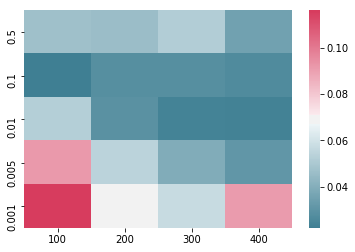

Y3.R.0 test
            100       200       300       400
0.5    0.695855  0.646127  0.667851  0.713340
0.1    0.715986  0.715763  0.713534  0.712792
0.01   0.600280  0.692054  0.710174  0.718700
0.005  0.423236  0.596076  0.669824  0.694803
0.001  0.238878  0.321624  0.621004  0.734060


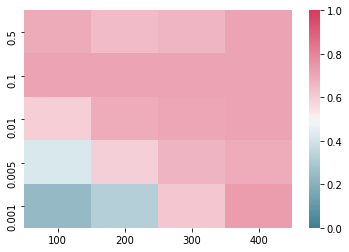

Y3.R.0 train
            100       200       300       400
0.5    0.999999  0.999999  0.999999  0.999999
0.1    0.999923  0.999999  0.999999  0.999999
0.01   0.803414  0.949140  0.983299  0.993565
0.005  0.568883  0.802720  0.904461  0.949906
0.001  0.159532  0.294865  0.496317  0.403895


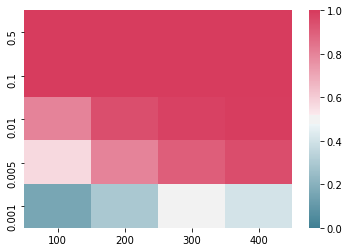

Y3.R.0 bcstd
            100       200       300       400
0.5    0.179162  0.034028  0.213448  0.336251
0.1    0.000943  0.010532  0.005456  0.009453
0.01   0.016918  0.012395  0.007914  0.007397
0.005  0.018998  0.014693  0.031010  0.033123
0.001  0.355061  0.303560  0.482260  0.649343


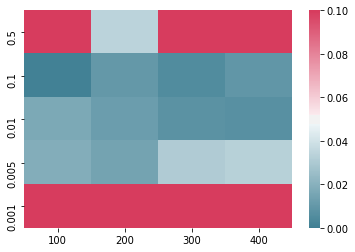

Y3.I.0 variance
            100       200       300       400
0.5    0.035823  0.048865  0.058540  0.080868
0.1    0.036341  0.031427  0.038217  0.040240
0.01   0.062627  0.045138  0.039527  0.036117
0.005  0.083939  0.060601  0.023001  0.018052
0.001  0.121590  0.117776  0.089773  0.083675


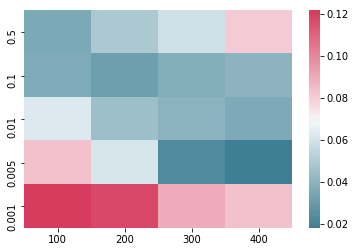

Y3.I.0 test
            100       200       300       400
0.5    0.695274  0.623627  0.570516  0.600582
0.1    0.670608  0.668263  0.669434  0.675134
0.01   0.564922  0.656909  0.672756  0.676918
0.005  0.402244  0.567576  0.641329  0.665621
0.001  0.121430  0.225166  0.379999  0.318545


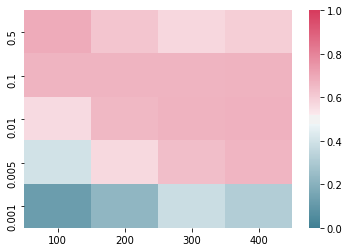

Y3.I.0 train
            100       200       300       400
0.5    0.999999  0.999999  0.999999  0.999999
0.1    0.999918  0.999999  0.999999  0.999999
0.01   0.787501  0.941302  0.979909  0.991908
0.005  0.554783  0.786514  0.892621  0.941059
0.001  0.155743  0.288180  0.481864  0.390836


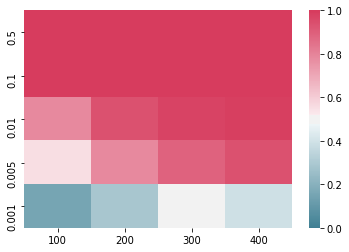

Y3.I.0 bcstd
            100       200       300       400
0.5    0.355517  0.107487  0.044829  0.162334
0.1    0.009846  0.018695  0.010291  0.009256
0.01   0.016085  0.018413  0.018449  0.010377
0.005  0.013951  0.014972  0.012065  0.013654
0.001  0.141401  0.105206  0.126263  0.154828


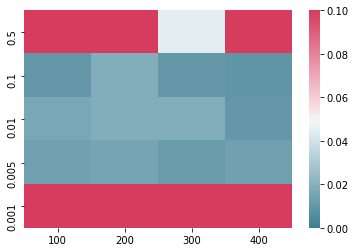

Y0.R.0 variance
            100       200       300       400
0.1    0.028682  0.024963  0.037252  0.031630
0.01   0.052831  0.040863  0.035023  0.032537
0.005  0.072021  0.055562  0.043368  0.041610


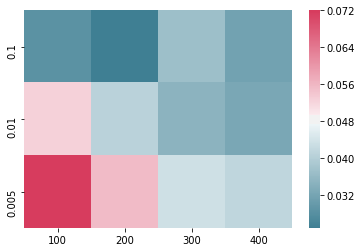

Y0.R.0 test
            100       200       300       400
0.1    0.682517  0.676526  0.671624  0.679341
0.01   0.572553  0.657467  0.679201  0.682884
0.005  0.407026  0.570694  0.637926  0.663480


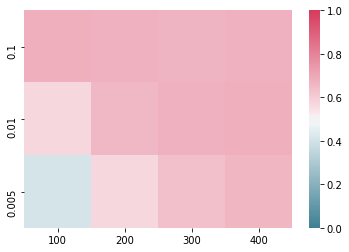

Y0.R.0 train
            100       200       300       400
0.1    0.999928  0.999999  0.999999  0.999999
0.01   0.804258  0.948970  0.983683  0.993806
0.005  0.569905  0.802176  0.899666  0.946194


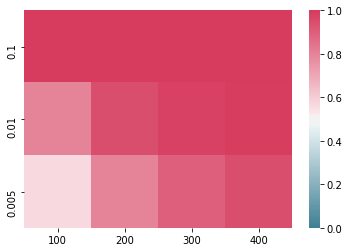

Y0.R.0 bcstd
            100       200       300       400
0.1    0.000114  0.007024  0.001265  0.004170
0.01   0.003354  0.000668  0.002937  0.000906
0.005  0.007297  0.004914  0.009157  0.008721


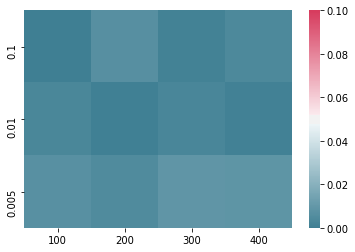

Y0.R.1 variance
            100       200       300       400
0.1    0.041877  0.046294  0.040344  0.029870
0.01   0.049682  0.038147  0.034464  0.038337
0.005  0.057352  0.046014  0.051026  0.047567


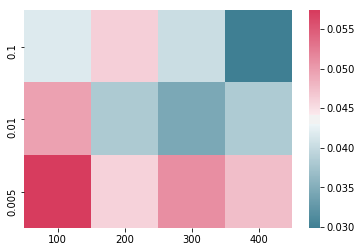

Y0.R.1 test
            100       200       300       400
0.1    0.550947  0.552132  0.546829  0.555713
0.01   0.476864  0.544022  0.557065  0.557446
0.005  0.343974  0.477550  0.525216  0.542130


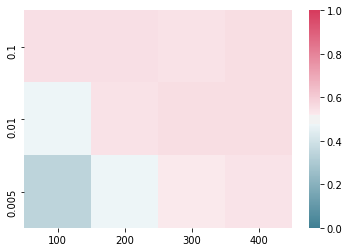

Y0.R.1 train
            100       200       300       400
0.1    0.999914  1.000000  1.000000  1.000000
0.01   0.778376  0.935729  0.976789  0.990905
0.005  0.546490  0.778009  0.883141  0.935125


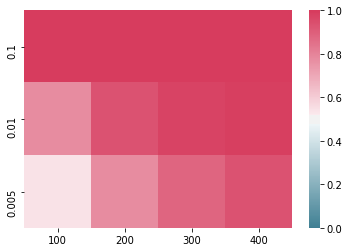

Y0.R.1 bcstd
            100       200       300       400
0.1    0.017532  0.019402  0.014753  0.016261
0.01   0.015504  0.016776  0.015203  0.016325
0.005  0.014188  0.015876  0.032243  0.033451


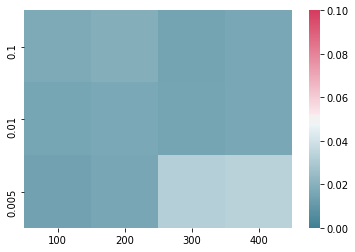

Y0.R.2 variance
            100       200       300       400
0.1    0.079793  0.056656  0.067544  0.072509
0.01   0.050386  0.058121  0.058479  0.059760
0.005  0.063001  0.051036  0.059288  0.058687


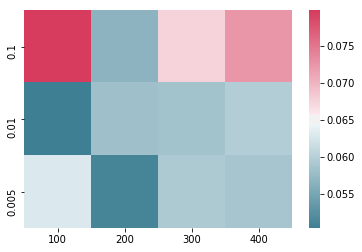

Y0.R.2 test
            100       200       300       400
0.1    0.414804  0.426085  0.429201  0.428574
0.01   0.401855  0.438811  0.442152  0.441140
0.005  0.302258  0.403209  0.440559  0.456816


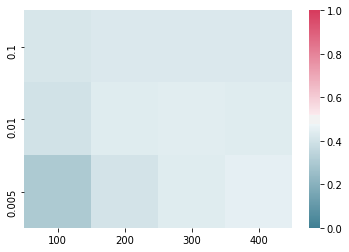

Y0.R.2 train
            100       200       300       400
0.1    0.999866  1.000000  1.000000  1.000000
0.01   0.763587  0.924540  0.971696  0.988491
0.005  0.532463  0.762861  0.867453  0.923073


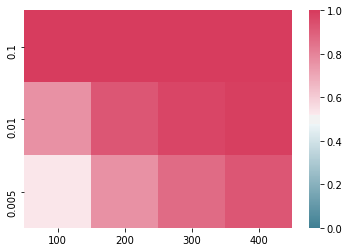

Y0.R.2 bcstd
            100       200       300       400
0.1    0.020126  0.012055  0.018120  0.009855
0.01   0.002732  0.002843  0.007468  0.013742
0.005  0.006206  0.002423  0.000427  0.001675


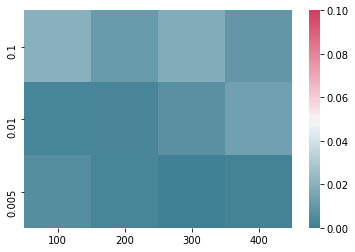

Y0.I.0 variance
            100       200       300       400
0.1    0.043601  0.040674  0.038141  0.031400
0.01   0.043404  0.039553  0.038258  0.033837
0.005  0.062629  0.042983  0.057340  0.057508


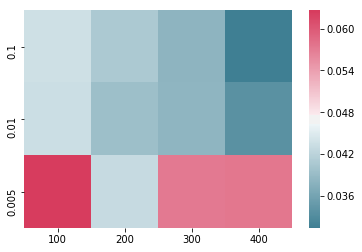

Y0.I.0 test
            100       200       300       400
0.1    0.646623  0.637165  0.635360  0.646243
0.01   0.532751  0.625358  0.646027  0.654200
0.005  0.371172  0.533759  0.627278  0.649620


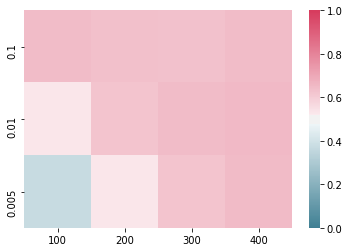

Y0.I.0 train
            100       200       300       400
0.1    0.999926  0.999998  0.999998  0.999998
0.01   0.786719  0.939240  0.978894  0.991628
0.005  0.553177  0.786419  0.890227  0.939859


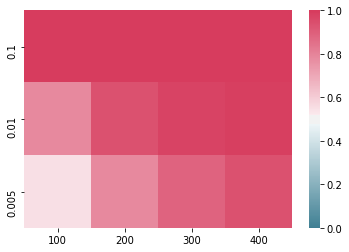

Y0.I.0 bcstd
            100       200       300       400
0.1    0.009048  0.005365  0.004496  0.000396
0.01   0.007908  0.011054  0.005271  0.003103
0.005  0.003017  0.007626  0.001053  0.001189


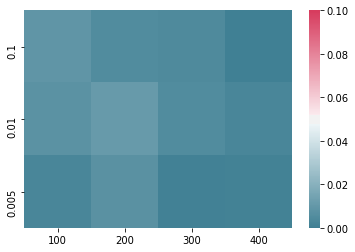

Y0.I.1 variance
            100       200       300       400
0.1    0.070819  0.066529  0.066429  0.069082
0.01   0.100942  0.076526  0.067357  0.068559
0.005  0.144495  0.098527  0.052975  0.054001


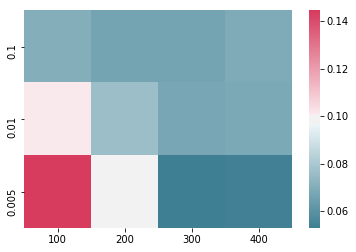

Y0.I.1 test
            100       200       300       400
0.1    0.533137  0.543820  0.539744  0.539443
0.01   0.442488  0.514630  0.535181  0.542042
0.005  0.306510  0.439099  0.526473  0.544411


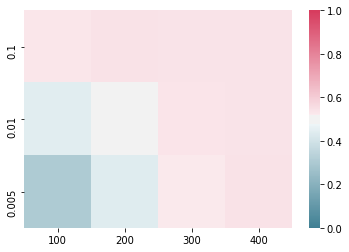

Y0.I.1 train
            100       200       300       400
0.1    0.999910  1.000000  1.000000  1.000000
0.01   0.768458  0.930578  0.974836  0.990045
0.005  0.538318  0.768866  0.872521  0.927653


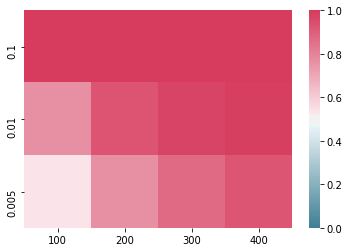

Y0.I.1 bcstd
            100       200       300       400
0.1    0.013409  0.006695  0.018429  0.015830
0.01   0.004245  0.007175  0.011842  0.009558
0.005  0.004146  0.005521  0.009110  0.007561


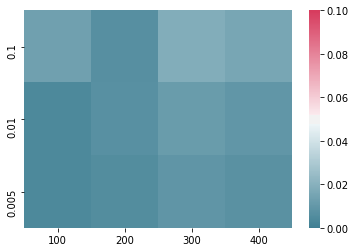

Y0.I.2 variance
            100       200       300       400
0.1    0.057334  0.048156  0.044793  0.040372
0.01   0.070378  0.053770  0.047990  0.044100
0.005  0.092542  0.066707  0.060687  0.048185


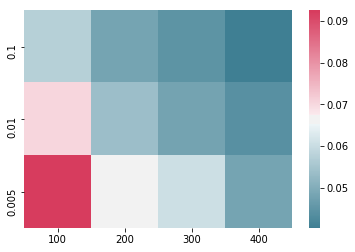

Y0.I.2 test
            100       200       300       400
0.1    0.495603  0.490309  0.497422  0.498295
0.01   0.434116  0.493962  0.501750  0.508079
0.005  0.319960  0.436027  0.477491  0.499008


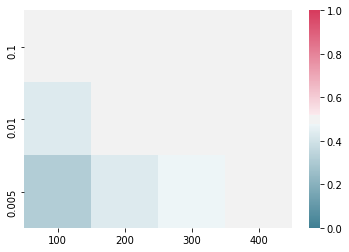

Y0.I.2 train
            100       200       300       400
0.1    0.999909  1.000000  1.000000  1.000000
0.01   0.765390  0.929839  0.974997  0.989679
0.005  0.530791  0.764272  0.872155  0.928073


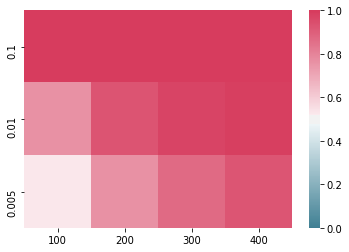

Y0.I.2 bcstd
            100       200       300       400
0.1    0.009823  0.009666  0.006949  0.012371
0.01   0.005479  0.006484  0.002229  0.004910
0.005  0.005635  0.008338  0.001218  0.000951


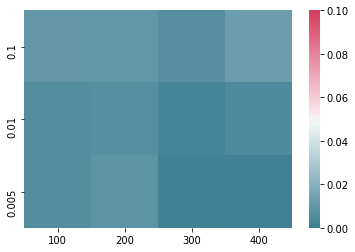

Y1.R.0 variance
            100       200       300       400
0.1    0.033633  0.033852  0.027850  0.029355
0.01   0.049699  0.035409  0.033217  0.034024
0.005  0.079879  0.050461  0.035717  0.033302


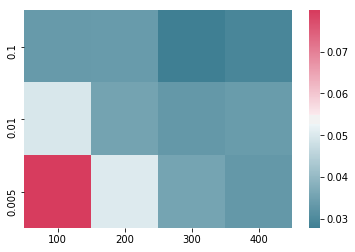

Y1.R.0 test
            100       200       300       400
0.1    0.708030  0.702802  0.704637  0.707557
0.01   0.589722  0.685182  0.705503  0.709560
0.005  0.416589  0.590612  0.655774  0.682216


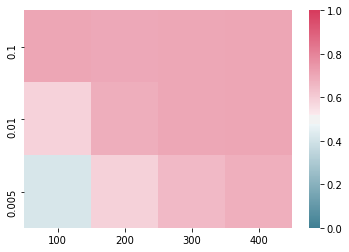

Y1.R.0 train
            100       200       300       400
0.1    0.999944  0.999999  0.999999  0.999999
0.01   0.803297  0.949645  0.984025  0.993884
0.005  0.568176  0.802140  0.900240  0.947608


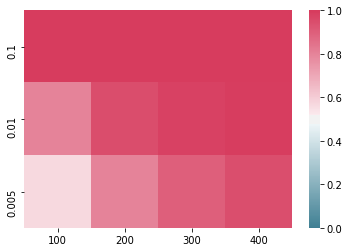

Y1.R.0 bcstd
            100       200       300       400
0.1    0.017433  0.016913  0.023876  0.018901
0.01   0.016550  0.015066  0.016841  0.014220
0.005  0.017718  0.015469  0.018395  0.017257


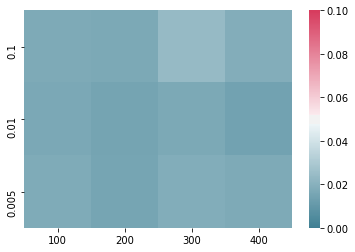

Y1.R.1 variance
            100       200       300       400
0.1    0.070559  0.108022  0.095166  0.105302
0.01   0.065629  0.083333  0.086546  0.083155
0.005  0.072816  0.069350  0.070269  0.064443


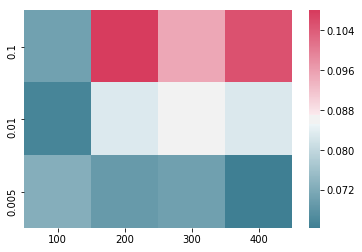

Y1.R.1 test
            100       200       300       400
0.1    0.514879  0.511887  0.507769  0.493886
0.01   0.447942  0.503150  0.514682  0.518242
0.005  0.324770  0.447277  0.492755  0.512721


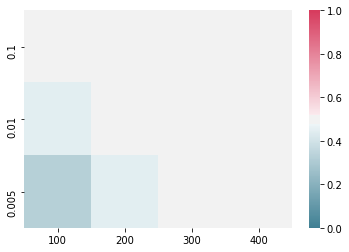

Y1.R.1 train
            100       200       300       400
0.1    0.999913  1.000000  1.000000  1.000000
0.01   0.771766  0.932647  0.976254  0.990455
0.005  0.539390  0.771986  0.883278  0.935333


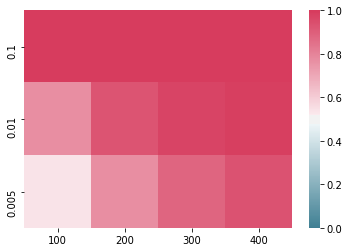

Y1.R.1 bcstd
            100       200       300       400
0.1    0.013587  0.019492  0.027048  0.023670
0.01   0.021890  0.022036  0.021496  0.022980
0.005  0.021288  0.023243  0.029906  0.031854


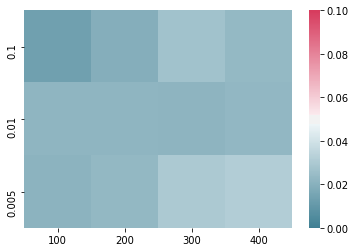

Y1.R.2 variance
            100       200       300       400
0.1    0.017627  0.029361  0.028565  0.032567
0.01   0.044212  0.027594  0.020430  0.022029
0.005  0.063163  0.047050  0.058476  0.051192


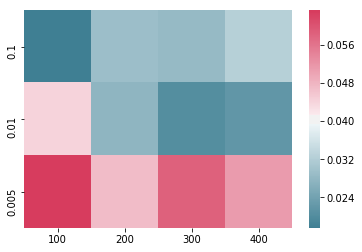

Y1.R.2 test
            100       200       300       400
0.1    0.418845  0.422295  0.421491  0.434290
0.01   0.394525  0.433165  0.437122  0.442483
0.005  0.293180  0.390476  0.402394  0.416893


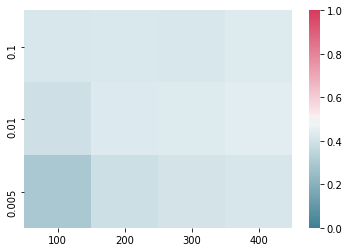

Y1.R.2 train
            100       200       300       400
0.1    0.999860  1.000000  1.000000  1.000000
0.01   0.752927  0.921835  0.970099  0.987473
0.005  0.523171  0.754150  0.866738  0.923409


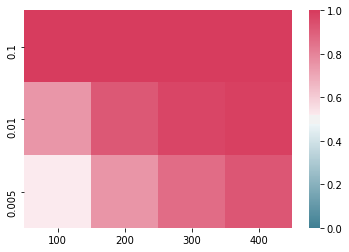

Y1.R.2 bcstd
            100       200       300       400
0.1    0.001746  0.005092  0.010265  0.004581
0.01   0.002857  0.000596  0.006616  0.003770
0.005  0.003377  0.004336  0.007101  0.009651


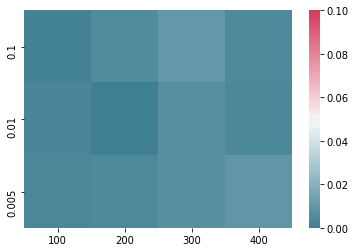

Y1.I.0 variance
            100       200       300       400
0.1    0.035814  0.035669  0.030831  0.030307
0.01   0.037134  0.034398  0.032365  0.032067
0.005  0.053851  0.037344  0.060182  0.058615


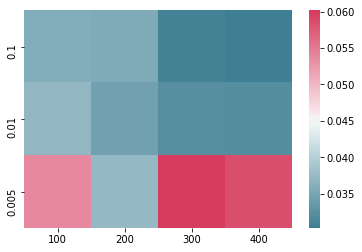

Y1.I.0 test
            100       200       300       400
0.1    0.672150  0.678608  0.669935  0.665675
0.01   0.563850  0.655621  0.673191  0.678117
0.005  0.390655  0.560954  0.634153  0.654180


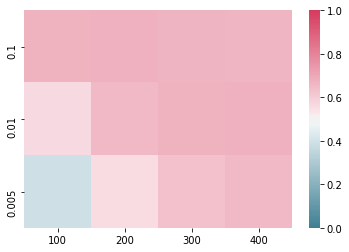

Y1.I.0 train
            100       200       300       400
0.1    0.999920  0.999999  0.999999  0.999999
0.01   0.792423  0.942588  0.980679  0.992448
0.005  0.559581  0.791516  0.896229  0.944119


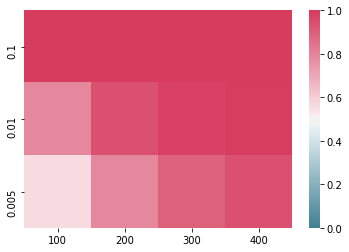

Y1.I.0 bcstd
            100       200       300       400
0.1    0.011813  0.003789  0.014675  0.015053
0.01   0.001825  0.004058  0.009658  0.010449
0.005  0.001288  0.002354  0.005482  0.001664


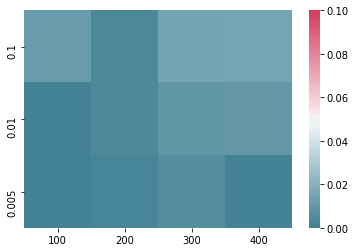

Y1.I.1 variance
            100       200       300       400
0.1    0.036988  0.048946  0.046335  0.027047
0.01   0.072180  0.051442  0.042739  0.042076
0.005  0.109700  0.071827  0.036510  0.030038


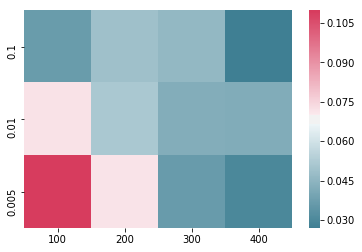

Y1.I.1 test
            100       200       300       400
0.1    0.565276  0.560608  0.568864  0.562664
0.01   0.479180  0.553118  0.568877  0.575330
0.005  0.338063  0.477969  0.538639  0.559529


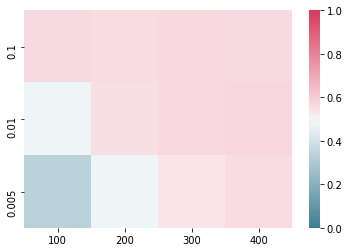

Y1.I.1 train
            100       200       300       400
0.1    0.999932  1.000000  1.000000  1.000000
0.01   0.774659  0.933927  0.976604  0.990645
0.005  0.540839  0.773676  0.881790  0.933729


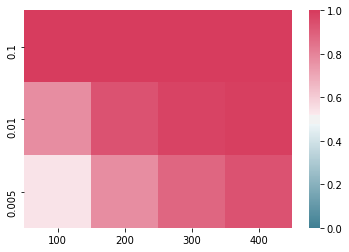

Y1.I.1 bcstd
            100       200       300       400
0.1    0.047692  0.051560  0.048210  0.049177
0.01   0.032194  0.045487  0.045306  0.043875
0.005  0.023966  0.034363  0.003005  0.004256


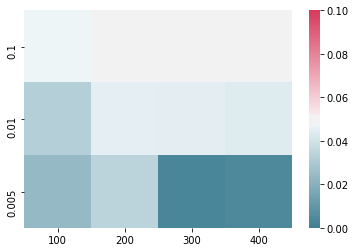

Y1.I.2 variance
            100       200       300       400
0.1    0.034424  0.041324  0.046675  0.047559
0.01   0.046947  0.035702  0.031980  0.032681
0.005  0.072152  0.045550  0.084270  0.078193


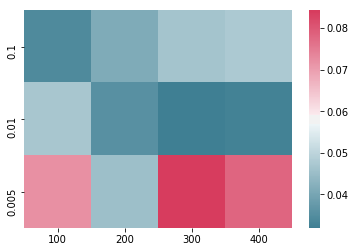

Y1.I.2 test
            100       200       300       400
0.1    0.490970  0.475761  0.483565  0.478098
0.01   0.401669  0.467643  0.485382  0.486557
0.005  0.286354  0.399839  0.451958  0.470120


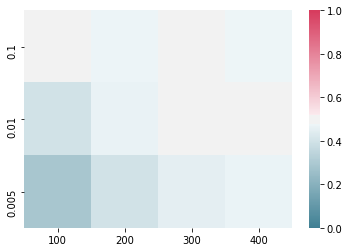

Y1.I.2 train
            100       200       300       400
0.1    0.999902  1.000000  1.000000  1.000000
0.01   0.766327  0.929599  0.974735  0.989897
0.005  0.533044  0.766341  0.872233  0.928787


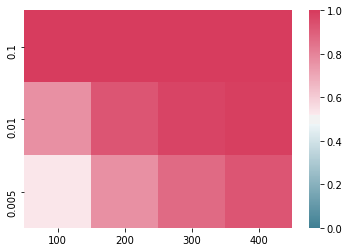

Y1.I.2 bcstd
            100       200       300       400
0.1    0.006267  0.017522  0.018382  0.018036
0.01   0.004734  0.007986  0.012420  0.016542
0.005  0.001779  0.006126  0.004444  0.008488


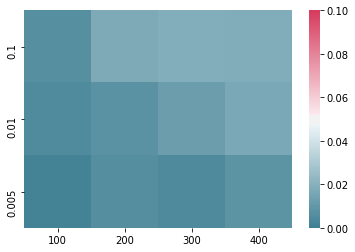

Y2.R.0 variance
            100       200       300       400
0.1    0.025783  0.027580  0.022585  0.024495
0.01   0.052386  0.032920  0.025775  0.026807
0.005  0.085586  0.050645  0.044664  0.036886


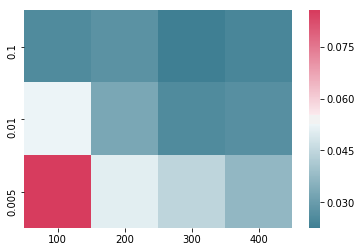

Y2.R.0 test
            100       200       300       400
0.1    0.713847  0.715351  0.711832  0.716628
0.01   0.595694  0.692654  0.713569  0.717367
0.005  0.420474  0.596556  0.660240  0.688752


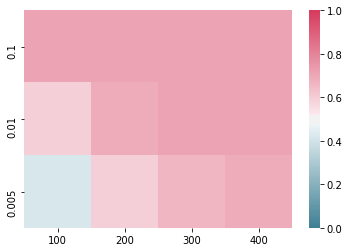

Y2.R.0 train
            100       200       300       400
0.1    0.999942  0.999999  0.999999  0.999999
0.01   0.806203  0.950890  0.984170  0.994061
0.005  0.573117  0.805413  0.904509  0.950427


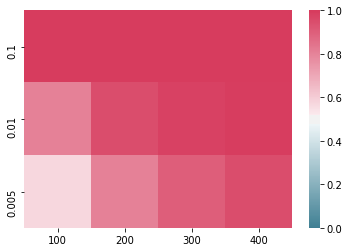

Y2.R.0 bcstd
            100       200       300       400
0.1    0.008162  0.001258  0.006087  0.005991
0.01   0.010471  0.008487  0.004772  0.000031
0.005  0.017113  0.011523  0.026818  0.027367


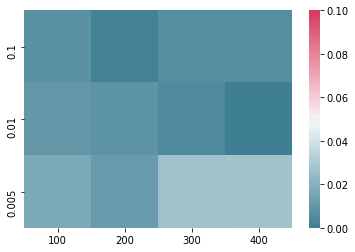

Y2.R.1 variance
            100       200       300       400
0.1    0.077014  0.077851  0.077360  0.066069
0.01   0.083084  0.080708  0.076391  0.072122
0.005  0.095565  0.083363  0.077334  0.078609


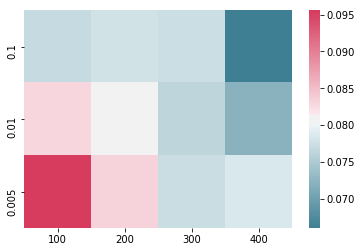

Y2.R.1 test
            100       200       300       400
0.1    0.529428  0.524281  0.523122  0.528320
0.01   0.459846  0.522921  0.535236  0.536778
0.005  0.332347  0.457245  0.506023  0.526468


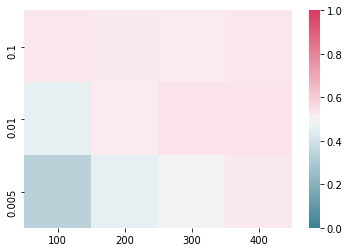

Y2.R.1 train
            100       200       300       400
0.1    0.999909  1.000000  1.000000  1.000000
0.01   0.779136  0.937197  0.978239  0.991275
0.005  0.544883  0.779034  0.887291  0.938554


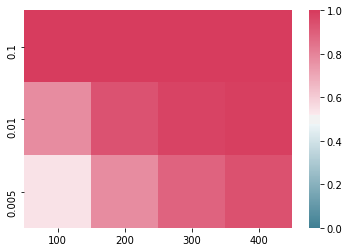

Y2.R.1 bcstd
            100       200       300       400
0.1    0.028093  0.010484  0.022829  0.011535
0.01   0.015605  0.012580  0.013692  0.013615
0.005  0.019702  0.017037  0.031481  0.035692


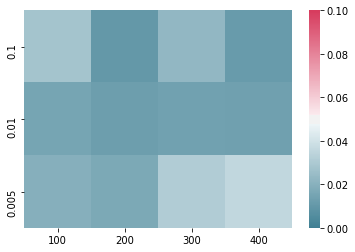

Y2.R.2 variance
            100       200       300       400
0.1    0.045133  0.054894  0.055190  0.035840
0.01   0.052674  0.051210  0.052593  0.051277
0.005  0.063034  0.051582  0.050297  0.048352


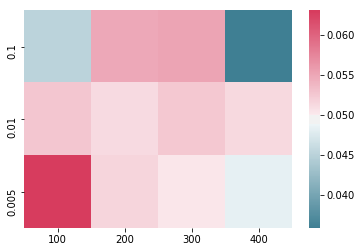

Y2.R.2 test
            100       200       300       400
0.1    0.470951  0.466635  0.463671  0.477981
0.01   0.429005  0.477761  0.482336  0.479988
0.005  0.318644  0.429450  0.444121  0.457972


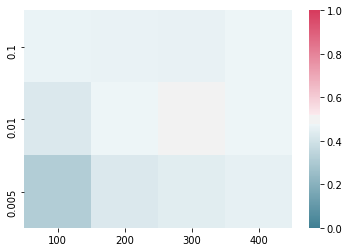

Y2.R.2 train
            100       200       300       400
0.1    0.999843  1.000000  1.000000  1.000000
0.01   0.760729  0.924029  0.971013  0.987787
0.005  0.529892  0.760820  0.865831  0.921931


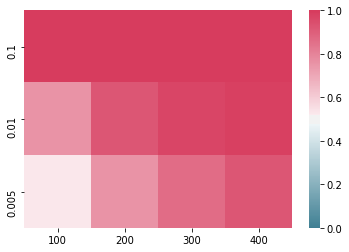

Y2.R.2 bcstd
            100       200       300       400
0.1    0.000745  0.016908  0.006792  0.007028
0.01   0.004887  0.009364  0.007776  0.007361
0.005  0.004395  0.008742  0.002856  0.002830


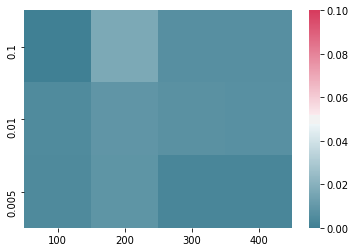

Y2.I.0 variance
            100       200       300       400
0.1    0.022803  0.017201  0.024014  0.024895
0.01   0.040354  0.023304  0.020648  0.021560
0.005  0.064705  0.041259  0.051730  0.048310


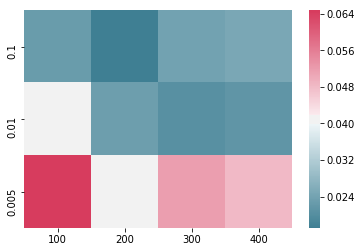

Y2.I.0 test
            100       200       300       400
0.1    0.674150  0.671523  0.677200  0.669719
0.01   0.577645  0.661854  0.678353  0.680136
0.005  0.408252  0.573066  0.645260  0.667079


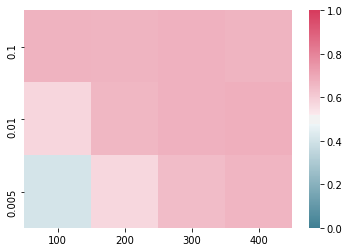

Y2.I.0 train
            100       200       300       400
0.1    0.999929  0.999999  0.999999  0.999999
0.01   0.789674  0.942251  0.980587  0.992586
0.005  0.558391  0.789552  0.896461  0.943710


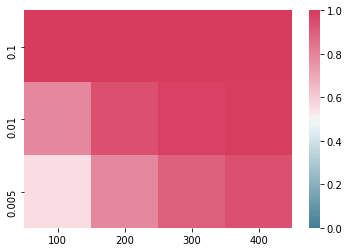

Y2.I.0 bcstd
            100       200       300       400
0.1    0.007868  0.000955  0.012278  0.008412
0.01   0.016858  0.013455  0.011004  0.011793
0.005  0.015976  0.017283  0.008274  0.009263


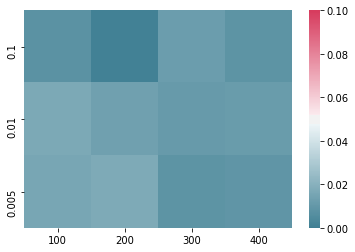

Y2.I.1 variance
            100       200       300       400
0.1    0.040797  0.036174  0.031106  0.038191
0.01   0.063389  0.041864  0.034476  0.033172
0.005  0.097093  0.063241  0.050761  0.047328


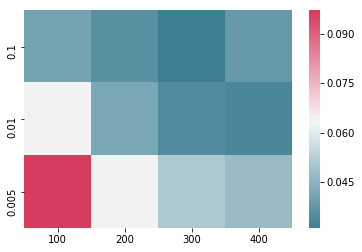

Y2.I.1 test
            100       200       300       400
0.1    0.563674  0.564378  0.569527  0.571049
0.01   0.482774  0.557689  0.574792  0.573562
0.005  0.339942  0.482079  0.539655  0.559129


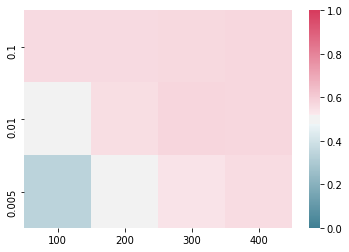

Y2.I.1 train
            100       200       300       400
0.1    0.999922  1.000000  1.000000  1.000000
0.01   0.776215  0.933890  0.976628  0.990518
0.005  0.541310  0.775035  0.881720  0.933755


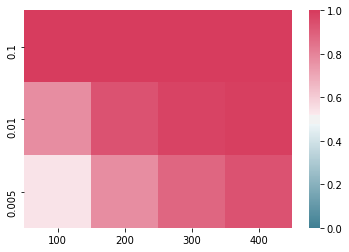

Y2.I.1 bcstd
            100       200       300       400
0.1    0.027434  0.026522  0.026937  0.017877
0.01   0.012751  0.015547  0.021299  0.020530
0.005  0.005767  0.013188  0.013334  0.013790


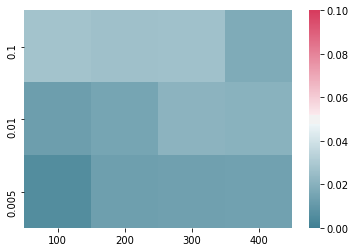

Y2.I.2 variance
            100       200       300       400
0.1    0.045277  0.045436  0.056457  0.053672
0.01   0.071263  0.052840  0.049552  0.049755
0.005  0.089333  0.075442  0.089088  0.079181


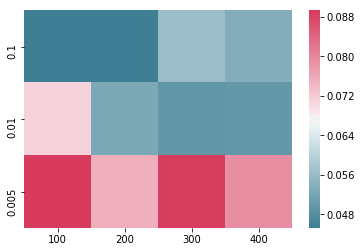

Y2.I.2 test
            100       200       300       400
0.1    0.513555  0.519880  0.516718  0.524752
0.01   0.430533  0.504727  0.520325  0.527597
0.005  0.305828  0.428170  0.483032  0.503394


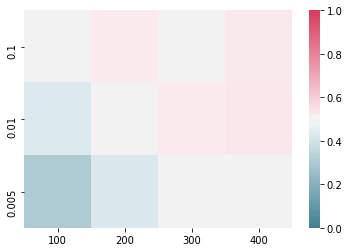

Y2.I.2 train
            100       200       300       400
0.1    0.999901  1.000000  1.000000  1.000000
0.01   0.770928  0.931200  0.975393  0.989709
0.005  0.537017  0.769262  0.876845  0.931356


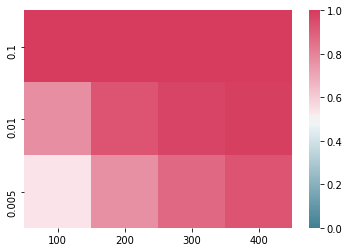

Y2.I.2 bcstd
            100       200       300       400
0.1    0.001404  0.000081  0.013677  0.009888
0.01   0.008025  0.000021  0.001093  0.003869
0.005  0.010602  0.008554  0.007804  0.006884


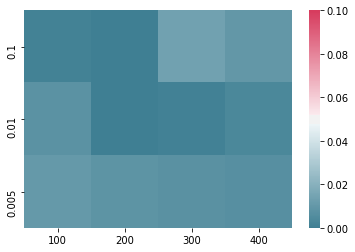

Y3.R.1 variance
            100       200       300       400
0.1    0.057861  0.054307  0.072286  0.061569
0.01   0.083978  0.065938  0.063744  0.062532
0.005  0.092234  0.084590  0.070471  0.067058


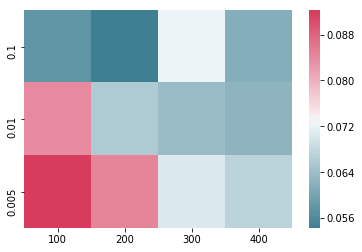

Y3.R.1 test
            100       200       300       400
0.1    0.545774  0.547637  0.542184  0.551805
0.01   0.472836  0.542223  0.556245  0.556283
0.005  0.334688  0.472328  0.509428  0.530020


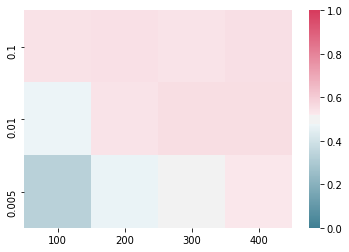

Y3.R.1 train
            100       200       300       400
0.1    0.999862  1.000000  1.000000  1.000000
0.01   0.775841  0.933948  0.975334  0.989558
0.005  0.542250  0.775460  0.885186  0.936021


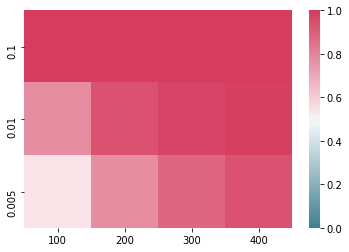

Y3.R.1 bcstd
            100       200       300       400
0.1    0.016577  0.005726  0.005190  0.007132
0.01   0.003056  0.003074  0.011180  0.009537
0.005  0.008640  0.004057  0.027645  0.027871


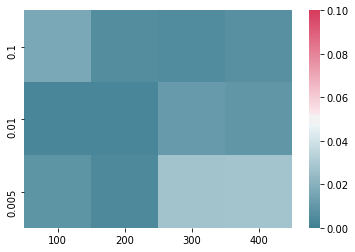

Y3.R.2 variance
            100       200       300       400
0.1    0.039823  0.041979  0.039027  0.034618
0.01   0.070813  0.051670  0.045845  0.046431
0.005  0.080956  0.063579  0.042630  0.044668


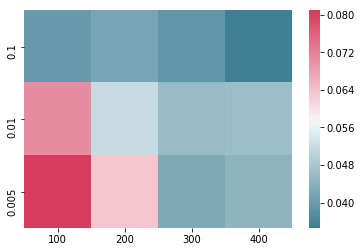

Y3.R.2 test
            100       200       300       400
0.1    0.495934  0.488406  0.491341  0.494542
0.01   0.445282  0.497362  0.504579  0.501641
0.005  0.326589  0.442418  0.455967  0.469999


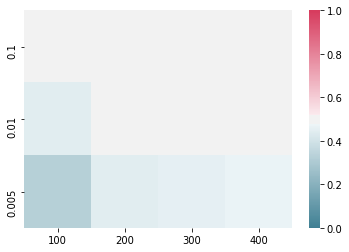

Y3.R.2 train
            100       200       300       400
0.1    0.999842  1.000000  1.000000  1.000000
0.01   0.762400  0.923813  0.970123  0.986864
0.005  0.533343  0.762901  0.869380  0.924414


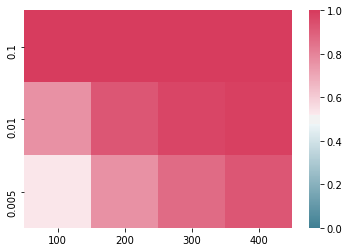

Y3.R.2 bcstd
            100       200       300       400
0.1    0.005322  0.015538  0.008652  0.004391
0.01   0.001791  0.003036  0.005669  0.008259
0.005  0.003574  0.000165  0.013256  0.010709


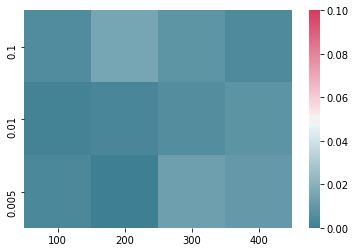

Y3.I.1 variance
            100       200       300       400
0.1    0.042951  0.044669  0.043434  0.049022
0.01   0.067427  0.059105  0.050674  0.048636
0.005  0.091358  0.067518  0.053600  0.049253


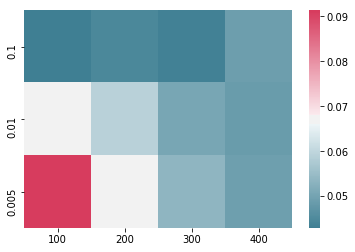

Y3.I.1 test
            100       200       300       400
0.1    0.563869  0.571281  0.563760  0.569881
0.01   0.484925  0.557249  0.574287  0.577976
0.005  0.344042  0.483567  0.540636  0.557536


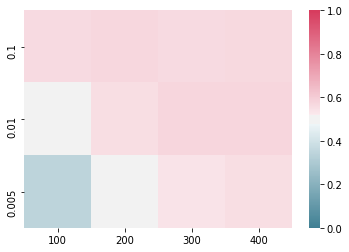

Y3.I.1 train
            100       200       300       400
0.1    0.999888  1.000000  1.000000  1.000000
0.01   0.775824  0.933320  0.975466  0.989836
0.005  0.544746  0.776477  0.883036  0.934582


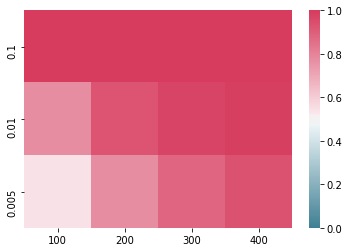

Y3.I.1 bcstd
            100       200       300       400
0.1    0.011729  0.000593  0.011915  0.014291
0.01   0.008717  0.009030  0.006513  0.007018
0.005  0.002474  0.005861  0.011815  0.014240


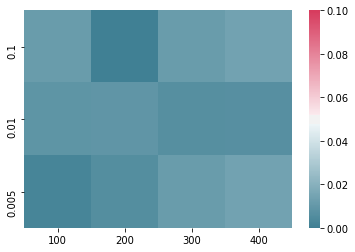

Y3.I.2 variance
            100       200       300       400
0.1    0.055174  0.042278  0.039089  0.043626
0.01   0.074002  0.054081  0.046073  0.049281
0.005  0.105869  0.076734  0.066970  0.057849


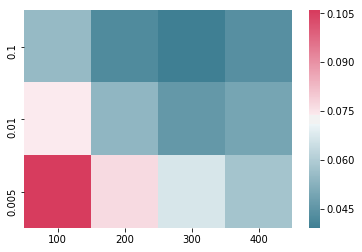

Y3.I.2 test
            100       200       300       400
0.1    0.503483  0.503742  0.517841  0.513985
0.01   0.434796  0.503050  0.518185  0.521823
0.005  0.312326  0.435964  0.482170  0.500326


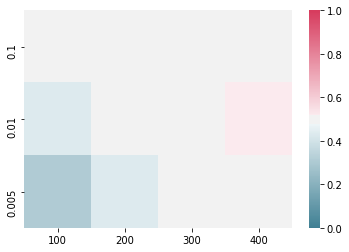

Y3.I.2 train
            100       200       300       400
0.1    0.999877  1.000000  1.000000  1.000000
0.01   0.768539  0.930001  0.974071  0.988817
0.005  0.537870  0.769077  0.874653  0.928301


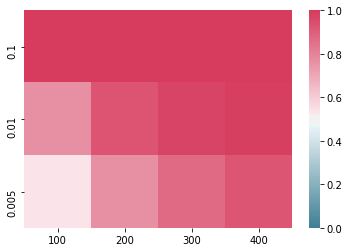

Y3.I.2 bcstd
            100       200       300       400
0.1    0.006114  0.006538  0.007066  0.010294
0.01   0.007446  0.005186  0.009061  0.010175
0.005  0.006872  0.007936  0.005843  0.007664


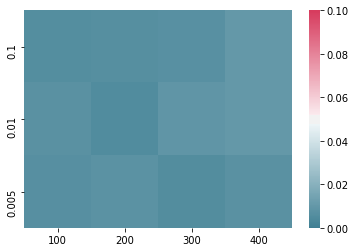

Y4.R.0 variance
            100       200       300       400
0.1    0.037604  0.038010  0.040083  0.041655
0.01   0.085532  0.054149  0.047702  0.043834
0.005  0.128782  0.082210  0.042153  0.030742


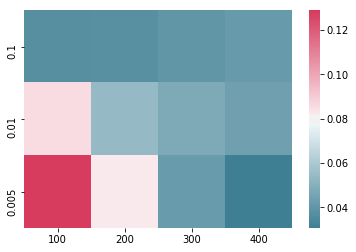

Y4.R.0 test
            100       200       300       400
0.1    0.711150  0.710895  0.713718  0.702739
0.01   0.586798  0.681037  0.703864  0.712261
0.005  0.414775  0.585653  0.662939  0.691201


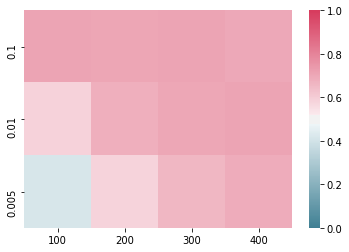

Y4.R.0 train
            100       200       300       400
0.1    0.999921  0.999999  0.999999  0.999999
0.01   0.801539  0.947880  0.982963  0.993511
0.005  0.569341  0.801878  0.902309  0.948196


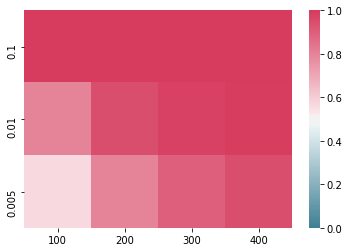

Y4.R.0 bcstd
            100       200       300       400
0.1    0.008784  0.009347  0.010262  0.007245
0.01   0.003914  0.003836  0.006344  0.010355
0.005  0.009056  0.002449  0.022697  0.021329


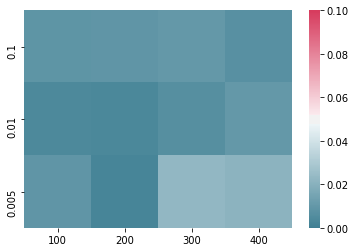

Y4.R.1 variance
            100       200       300       400
0.1    0.034176  0.036257  0.044470  0.028637
0.01   0.064947  0.046701  0.040809  0.040303
0.005  0.090596  0.068859  0.053010  0.044141


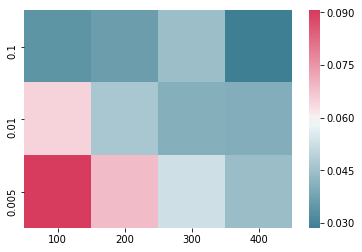

Y4.R.1 test
            100       200       300       400
0.1    0.556255  0.556378  0.550475  0.550642
0.01   0.486510  0.554676  0.564827  0.569383
0.005  0.346196  0.484165  0.501093  0.525660


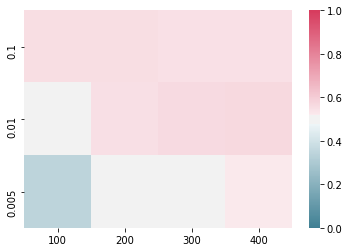

Y4.R.1 train
            100       200       300       400
0.1    0.999852  1.000000  1.000000  1.000000
0.01   0.771924  0.931086  0.974803  0.989327
0.005  0.540232  0.771017  0.882590  0.933831


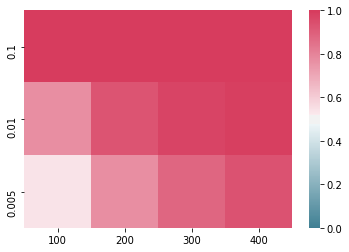

Y4.R.1 bcstd
            100       200       300       400
0.1    0.006542  0.002228  0.014143  0.001450
0.01   0.002082  0.004923  0.006106  0.004721
0.005  0.006097  0.002128  0.024501  0.026300


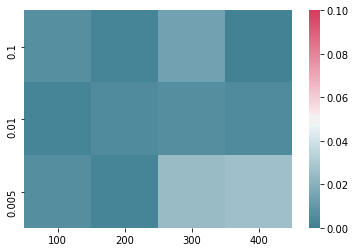

Y4.R.2 variance
            100       200       300       400
0.1    0.040676  0.033280  0.035661  0.034923
0.01   0.067978  0.046980  0.039346  0.037574
0.005  0.093160  0.067584  0.033491  0.029787


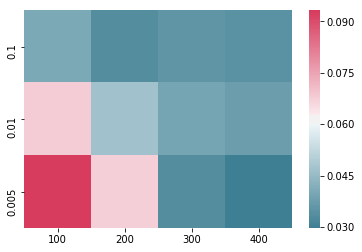

Y4.R.2 test
            100       200       300       400
0.1    0.486012  0.481043  0.490540  0.492267
0.01   0.441648  0.491158  0.497910  0.499008
0.005  0.324069  0.439974  0.450302  0.467129


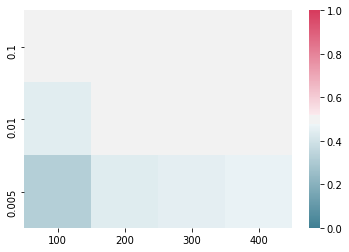

Y4.R.2 train
            100       200       300       400
0.1    0.999812  1.000000  1.000000  1.000000
0.01   0.766521  0.925715  0.970651  0.987129
0.005  0.537693  0.765660  0.869588  0.924214


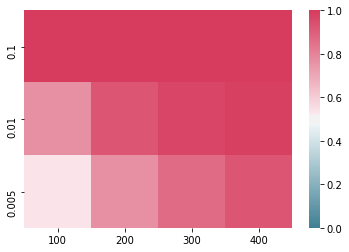

Y4.R.2 bcstd
            100       200       300       400
0.1    0.027995  0.026554  0.010271  0.013131
0.01   0.005199  0.012779  0.012981  0.016491
0.005  0.002403  0.004230  0.014341  0.016562


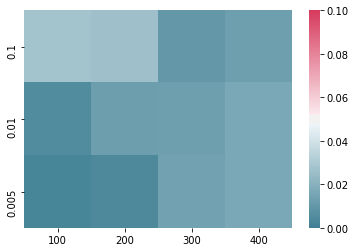

Y4.I.0 variance
            100       200       300       400
0.1    0.047158  0.050653  0.049184  0.054599
0.01   0.089453  0.067828  0.057950  0.052018
0.005  0.114280  0.091697  0.045419  0.036276


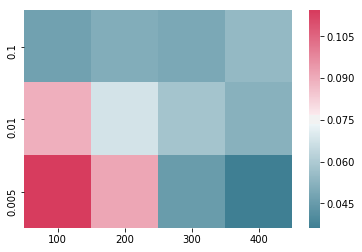

Y4.I.0 test
            100       200       300       400
0.1    0.647477  0.651833  0.651328  0.652808
0.01   0.539069  0.633131  0.652499  0.657237
0.005  0.377361  0.539568  0.626803  0.650661


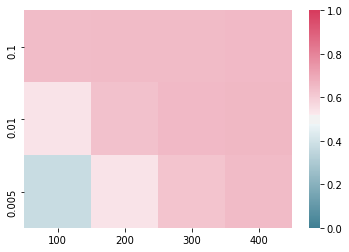

Y4.I.0 train
            100       200       300       400
0.1    0.999911  0.999999  0.999999  0.999999
0.01   0.790128  0.942069  0.979275  0.991739
0.005  0.560537  0.789700  0.894441  0.942601


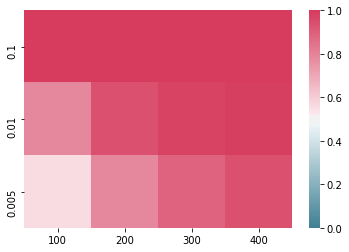

Y4.I.0 bcstd
            100       200       300       400
0.1    0.018970  0.012188  0.010630  0.016623
0.01   0.014183  0.013293  0.013188  0.014507
0.005  0.009545  0.011858  0.009079  0.010161


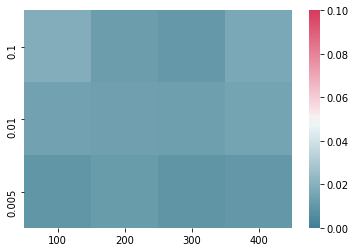

Y4.I.1 variance
            100       200       300       400
0.1    0.036058  0.031189  0.033716  0.031549
0.01   0.060348  0.041886  0.032325  0.032270
0.005  0.069909  0.059366  0.050273  0.044673


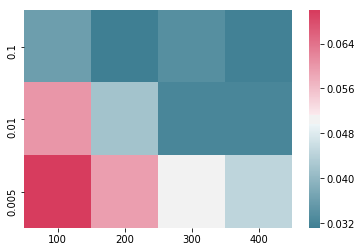

Y4.I.1 test
            100       200       300       400
0.1    0.590345  0.588993  0.594095  0.584548
0.01   0.505858  0.582398  0.594696  0.598356
0.005  0.356469  0.503489  0.560537  0.580504


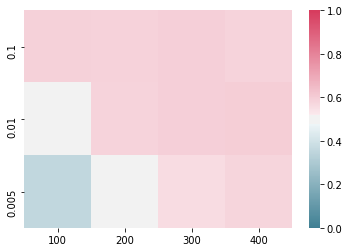

Y4.I.1 train
            100       200       300       400
0.1    0.999886  1.000000  1.000000  1.000000
0.01   0.780633  0.935796  0.975975  0.989683
0.005  0.548189  0.780382  0.888738  0.938400


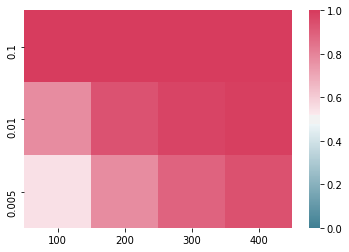

Y4.I.1 bcstd
            100       200       300       400
0.1    0.011912  0.020702  0.016599  0.011741
0.01   0.011188  0.015117  0.019233  0.018530
0.005  0.009312  0.013027  0.006474  0.009294


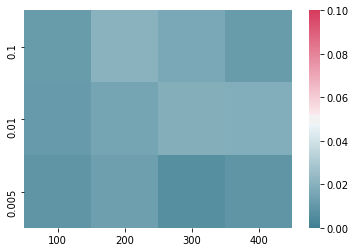

Y4.I.2 variance
            100       200       300       400
0.1    0.023280  0.025481  0.035296  0.032124
0.01   0.068274  0.045008  0.037280  0.035048
0.005  0.090686  0.067229  0.046824  0.038878


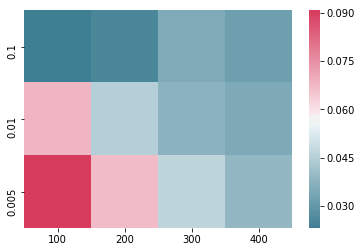

Y4.I.2 test
            100       200       300       400
0.1    0.520892  0.522448  0.527774  0.519495
0.01   0.452295  0.509926  0.519018  0.524051
0.005  0.328074  0.447991  0.497652  0.517388


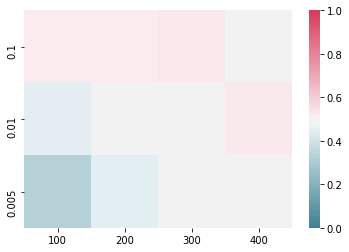

Y4.I.2 train
            100       200       300       400
0.1    0.999863  1.000000  1.000000  1.000000
0.01   0.771324  0.929850  0.973853  0.988862
0.005  0.539048  0.768787  0.875463  0.928403


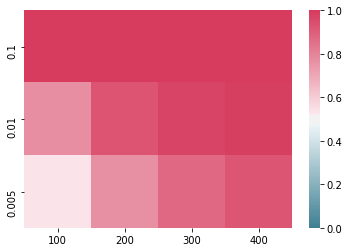

Y4.I.2 bcstd
            100       200       300       400
0.1    0.009362  0.010905  0.006085  0.000224
0.01   0.003570  0.005100  0.006591  0.005032
0.005  0.002982  0.003524  0.002770  0.004402


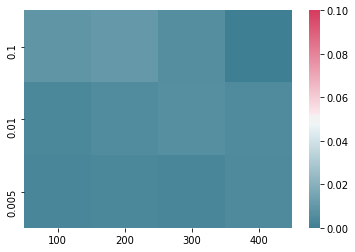

Y5.R.0 variance
            100       200       300       400
0.1    0.037452  0.036314  0.036789  0.037454
0.01   0.042608  0.028529  0.027538  0.029005
0.005  0.062529  0.040001  0.019302  0.017983


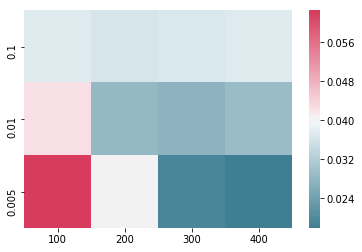

Y5.R.0 test
            100       200       300       400
0.1    0.679358  0.679409  0.678181  0.675771
0.01   0.576740  0.666929  0.681453  0.687510
0.005  0.408964  0.575644  0.665893  0.689652


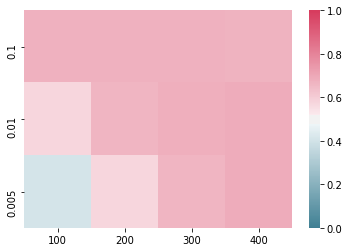

Y5.R.0 train
            100       200       300       400
0.1    0.999915  0.999999  0.999999  0.999999
0.01   0.801872  0.947073  0.982015  0.992787
0.005  0.567041  0.800033  0.900339  0.947034


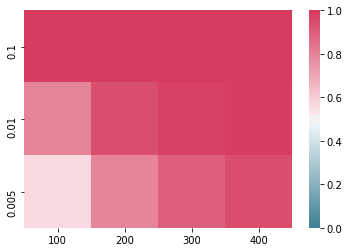

Y5.R.0 bcstd
            100       200       300       400
0.1    0.011917  0.004211  0.008474  0.006444
0.01   0.003441  0.001850  0.001913  0.008554
0.005  0.009802  0.004367  0.018430  0.020198


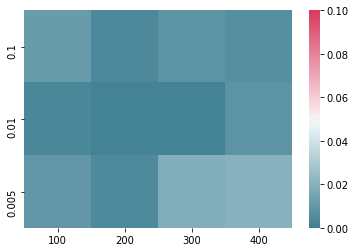

Y5.R.1 variance
            100       200       300       400
0.1    0.031194  0.035867  0.033136  0.030562
0.01   0.067094  0.043460  0.032592  0.032364
0.005  0.095829  0.068118  0.051021  0.045149


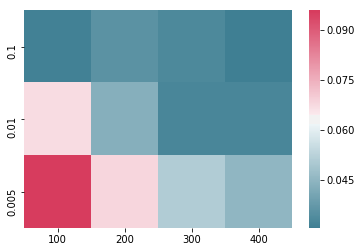

Y5.R.1 test
            100       200       300       400
0.1    0.535476  0.546448  0.540627  0.538281
0.01   0.463673  0.532674  0.544388  0.546876
0.005  0.323206  0.458727  0.502747  0.529231


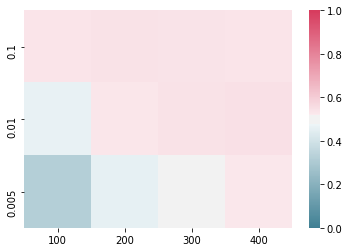

Y5.R.1 train
            100       200       300       400
0.1    0.999869  1.000000  1.000000  1.000000
0.01   0.768677  0.929003  0.973215  0.988815
0.005  0.536711  0.768268  0.881589  0.933644


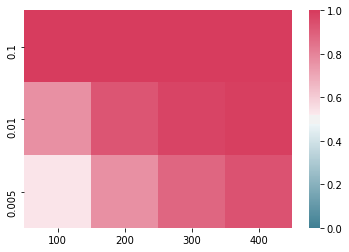

Y5.R.1 bcstd
            100       200       300       400
0.1    0.012395  0.006157  0.003517  0.001093
0.01   0.008764  0.006300  0.007643  0.004713
0.005  0.007412  0.007142  0.023338  0.023189


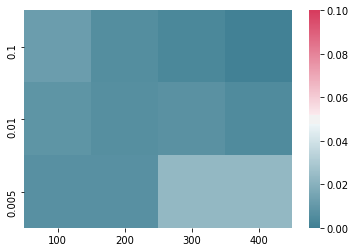

Y5.R.2 variance
            100       200       300       400
0.1    0.048930  0.043343  0.046969  0.031248
0.01   0.074424  0.050729  0.051352  0.046338
0.005  0.090201  0.073262  0.022857  0.023562


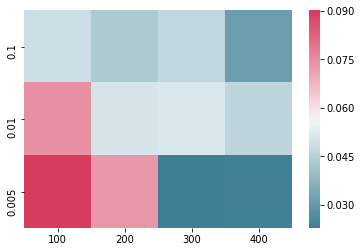

Y5.R.2 test
            100       200       300       400
0.1    0.487919  0.486916  0.493687  0.484797
0.01   0.437900  0.491892  0.499864  0.501815
0.005  0.317747  0.435158  0.446476  0.462268


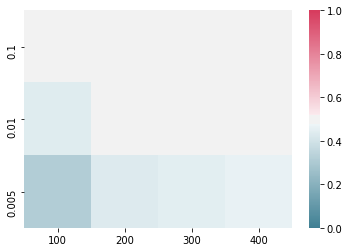

Y5.R.2 train
            100       200       300       400
0.1    0.999834  1.000000  1.000000  1.000000
0.01   0.768159  0.927511  0.971012  0.987467
0.005  0.536891  0.768559  0.871287  0.925605


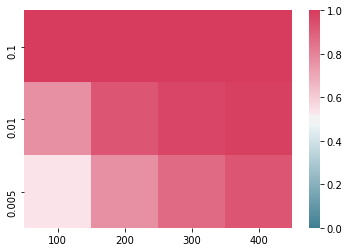

Y5.R.2 bcstd
            100       200       300       400
0.1    0.025193  0.036107  0.029984  0.031079
0.01   0.019851  0.022633  0.021765  0.027316
0.005  0.011965  0.017999  0.016409  0.018782


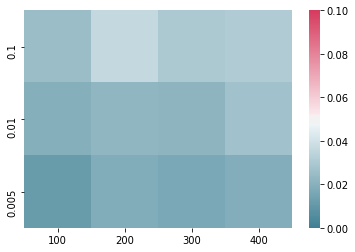

Y5.I.0 variance
            100       200       300       400
0.1    0.056506  0.053109  0.046997  0.050039
0.01   0.090836  0.074422  0.064509  0.058345
0.005  0.113618  0.096561  0.061367  0.050812


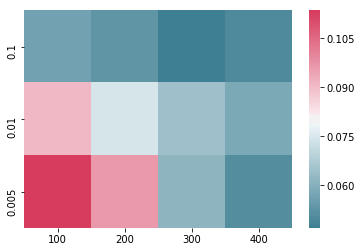

Y5.I.0 test
            100       200       300       400
0.1    0.649915  0.656160  0.647851  0.644480
0.01   0.554661  0.634515  0.650341  0.656465
0.005  0.396277  0.552253  0.630790  0.650733


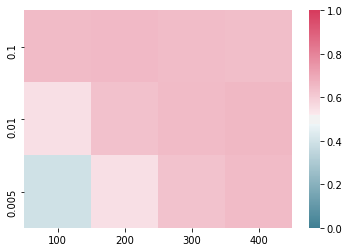

Y5.I.0 train
            100       200       300       400
0.1    0.999902  0.999998  0.999998  0.999998
0.01   0.799059  0.946532  0.982039  0.992729
0.005  0.567999  0.799255  0.900600  0.947043


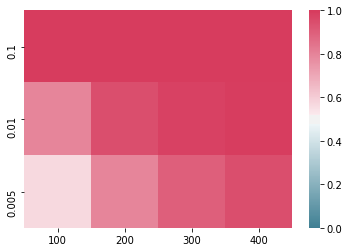

Y5.I.0 bcstd
            100       200       300       400
0.1    0.018364  0.011766  0.000103  0.009328
0.01   0.013334  0.014361  0.015726  0.014397
0.005  0.013579  0.015032  0.019496  0.020423


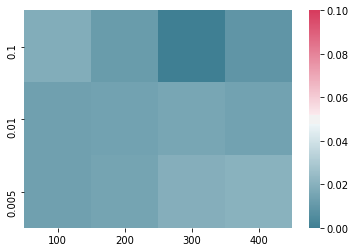

Y5.I.1 variance
            100       200       300       400
0.1    0.037141  0.033407  0.039002  0.035309
0.01   0.054280  0.029103  0.026860  0.029505
0.005  0.073843  0.053221  0.030801  0.026817


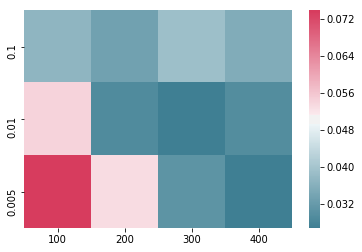

Y5.I.1 test
            100       200       300       400
0.1    0.573197  0.586982  0.575717  0.581564
0.01   0.508561  0.579100  0.589316  0.590972
0.005  0.365347  0.509140  0.559993  0.578871


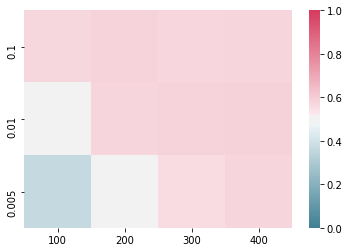

Y5.I.1 train
            100       200       300       400
0.1    0.999888  1.000000  1.000000  1.000000
0.01   0.781220  0.935674  0.976569  0.990123
0.005  0.549711  0.781092  0.889760  0.939591


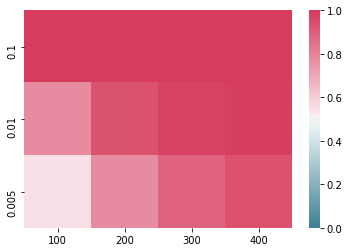

Y5.I.1 bcstd
            100       200       300       400
0.1    0.016230  0.012431  0.019920  0.016988
0.01   0.013788  0.019484  0.018125  0.019163
0.005  0.013826  0.014519  0.017746  0.015548


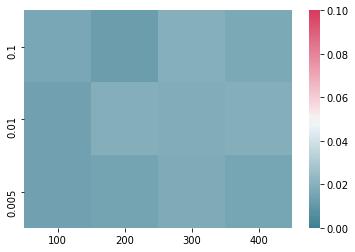

Y5.I.2 variance
            100       200       300       400
0.1    0.040181  0.027609  0.038124  0.050438
0.01   0.049855  0.038263  0.037204  0.035603
0.005  0.066839  0.052113  0.032259  0.026218


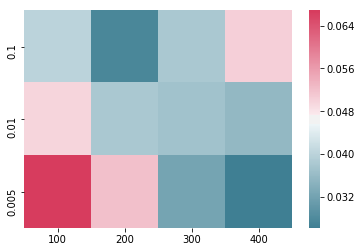

Y5.I.2 test
            100       200       300       400
0.1    0.498357  0.495075  0.498989  0.496427
0.01   0.439584  0.495513  0.499683  0.501992
0.005  0.323043  0.440032  0.478642  0.490819


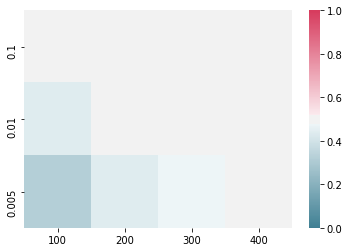

Y5.I.2 train
            100       200       300       400
0.1    0.999846  1.000000  1.000000  1.000000
0.01   0.767859  0.928453  0.972413  0.988047
0.005  0.536004  0.767557  0.875585  0.927983


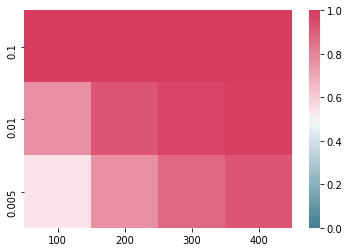

Y5.I.2 bcstd
            100       200       300       400
0.1    0.032626  0.037992  0.034546  0.039743
0.01   0.028015  0.031676  0.036677  0.035134
0.005  0.019637  0.027961  0.000925  0.002029


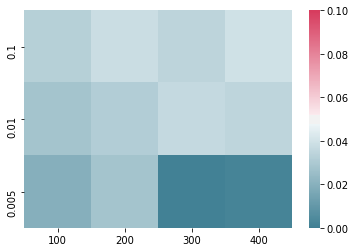

Y6.R.0 variance
            100       200       300       400
0.1    0.039843  0.033637  0.034346  0.032553
0.01   0.067802  0.041275  0.035638  0.033458
0.005  0.105326  0.064213  0.065170  0.053343


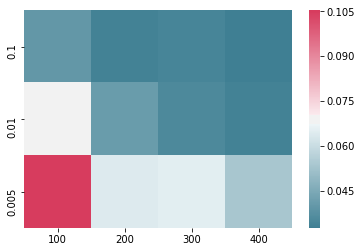

Y6.R.0 test
            100       200       300       400
0.1    0.543441  0.530290  0.544332  0.532651
0.01   0.450363  0.529590  0.547288  0.546560
0.005  0.314609  0.450839  0.501762  0.526407


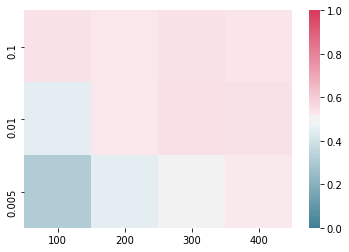

Y6.R.0 train
            100       200       300       400
0.1    0.999871  1.000000  1.000000  1.000000
0.01   0.762754  0.927037  0.973025  0.988724
0.005  0.529143  0.762146  0.877145  0.931302


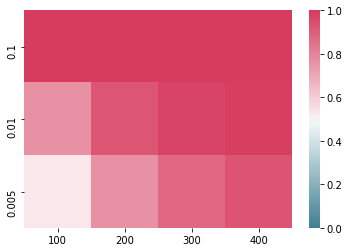

Y6.R.0 bcstd
            100       200       300       400
0.1    0.016755  0.016955  0.023604  0.016830
0.01   0.017438  0.021673  0.019802  0.023255
0.005  0.014772  0.018161  0.016887  0.018839


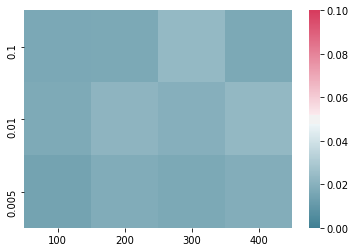

Y6.R.1 variance
            100       200       300       400
0.1    0.049677  0.045096  0.047322  0.033616
0.01   0.076824  0.063933  0.054227  0.049707
0.005  0.095212  0.075427  0.031004  0.021089


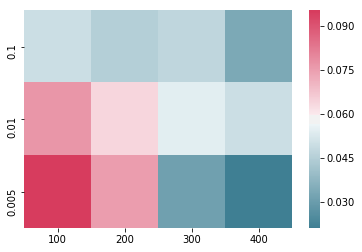

Y6.R.1 test
            100       200       300       400
0.1    0.498690  0.502347  0.499851  0.491494
0.01   0.441199  0.500030  0.508215  0.506976
0.005  0.323024  0.441419  0.454573  0.472142


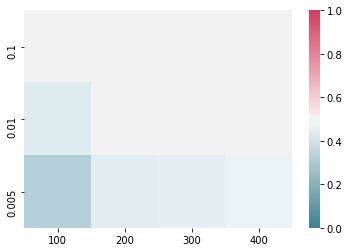

Y6.R.1 train
            100       200       300       400
0.1    0.999803  1.000000  1.000000  1.000000
0.01   0.763782  0.925611  0.970529  0.986956
0.005  0.533205  0.764280  0.869657  0.925179


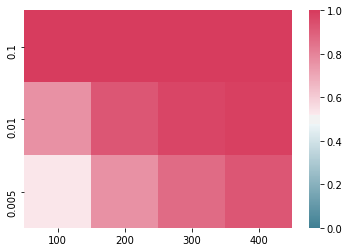

Y6.R.1 bcstd
            100       200       300       400
0.1    0.020787  0.021248  0.031390  0.012850
0.01   0.016515  0.023074  0.025041  0.021179
0.005  0.006745  0.015283  0.015071  0.016794


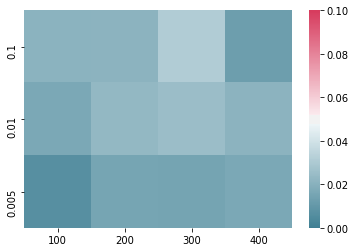

Y6.I.0 variance
            100       200       300       400
0.1    0.020774  0.030226  0.019477  0.036541
0.01   0.065683  0.042329  0.030931  0.031199
0.005  0.085715  0.062888  0.041921  0.037137


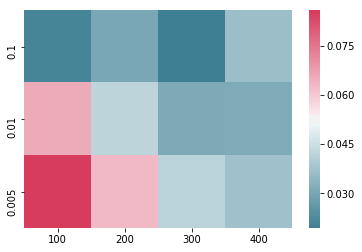

Y6.I.0 test
            100       200       300       400
0.1    0.578293  0.572697  0.570679  0.578799
0.01   0.483163  0.561079  0.575665  0.578047
0.005  0.343207  0.481198  0.530706  0.549306


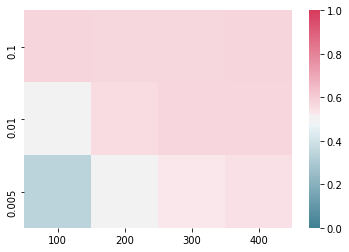

Y6.I.0 train
            100       200       300       400
0.1    0.999873  1.000000  1.000000  1.000000
0.01   0.779928  0.934231  0.975770  0.989814
0.005  0.547971  0.777580  0.890318  0.939753


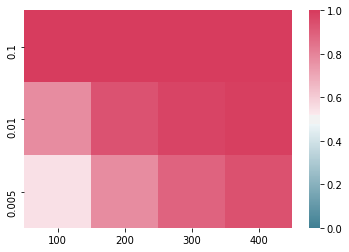

Y6.I.0 bcstd
            100       200       300       400
0.1    0.011433  0.017430  0.014227  0.015660
0.01   0.012343  0.018084  0.013261  0.016449
0.005  0.017990  0.014596  0.022680  0.017032


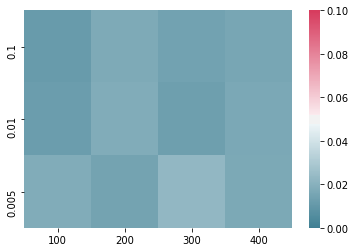

Y6.I.1 variance
            100       200       300       400
0.1    0.042932  0.036886  0.046876  0.035974
0.01   0.033333  0.030710  0.033477  0.030263
0.005  0.055508  0.033743  0.040162  0.035965


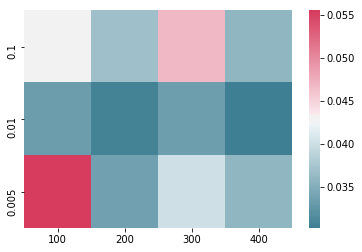

Y6.I.1 test
            100       200       300       400
0.1    0.466232  0.478236  0.462833  0.458729
0.01   0.431355  0.478686  0.479943  0.481405
0.005  0.318220  0.430802  0.467045  0.479307


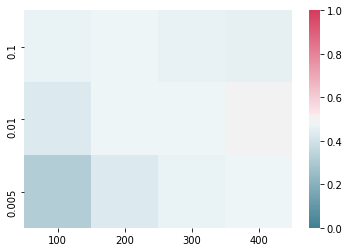

Y6.I.1 train
            100       200       300       400
0.1    0.999854  1.000000  1.000000  1.000000
0.01   0.768444  0.927453  0.972793  0.988552
0.005  0.536817  0.767651  0.875112  0.929348


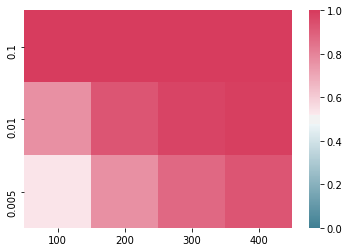

Y6.I.1 bcstd
            100       200       300       400
0.1    0.026642  0.024679  0.025176  0.035582
0.01   0.019908  0.026635  0.027640  0.030166
0.005  0.012839  0.020071  0.005268  0.005998


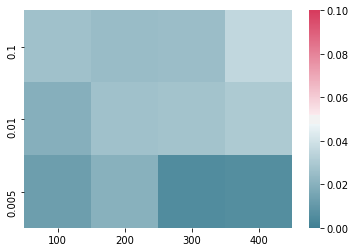

Y7.R.0 variance
            100       200       300       400
0.1    0.043307  0.031258  0.040640  0.042835
0.01   0.070767  0.042769  0.037881  0.034624
0.005  0.086929  0.064900  0.075856  0.066216


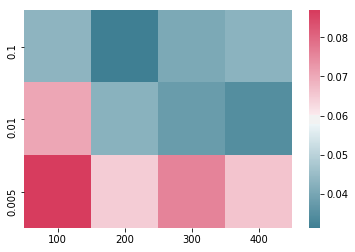

Y7.R.0 test
            100       200       300       400
0.1    0.520841  0.516868  0.518979  0.523341
0.01   0.452847  0.522093  0.529268  0.530700
0.005  0.322133  0.452074  0.487355  0.507098


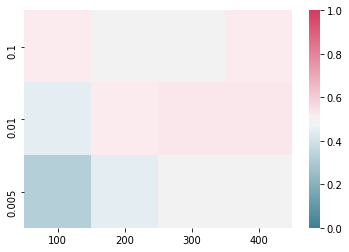

Y7.R.0 train
            100       200       300       400
0.1    0.999870  1.000000  1.000000  1.000000
0.01   0.759082  0.926374  0.972821  0.988776
0.005  0.526016  0.759639  0.870619  0.926355


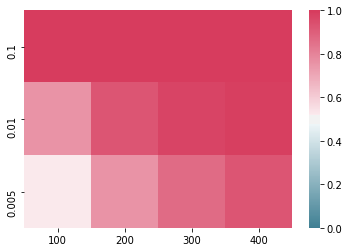

Y7.R.0 bcstd
            100       200       300       400
0.1    0.015203  0.007085  0.016686  0.006202
0.01   0.015345  0.010563  0.012775  0.013048
0.005  0.012433  0.012944  0.006018  0.005724


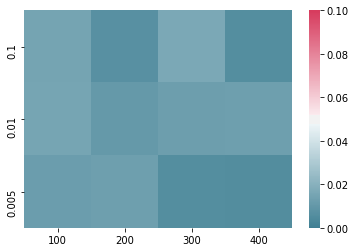

Y7.R.1 variance
            100       200       300       400
0.1    0.043240  0.063599  0.044838  0.066214
0.01   0.063436  0.057559  0.052050  0.052922
0.005  0.077017  0.065768  0.030995  0.026612


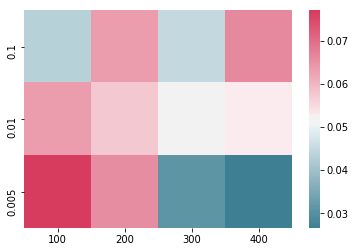

Y7.R.1 test
            100       200       300       400
0.1    0.476494  0.480897  0.483738  0.481507
0.01   0.429340  0.483940  0.492557  0.494460
0.005  0.314491  0.425842  0.442580  0.461405


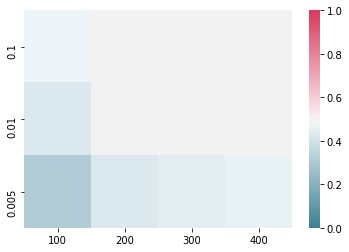

Y7.R.1 train
            100       200       300       400
0.1    0.999877  1.000000  1.000000  1.000000
0.01   0.765316  0.928430  0.973177  0.988414
0.005  0.532029  0.764595  0.869840  0.925399


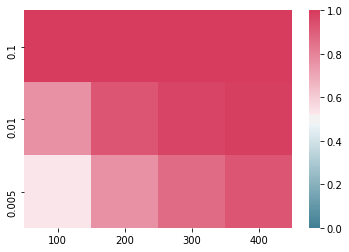

Y7.R.1 bcstd
            100       200       300       400
0.1    0.024736  0.037354  0.033297  0.037776
0.01   0.018692  0.029247  0.028652  0.028564
0.005  0.011939  0.020974  0.007312  0.007912


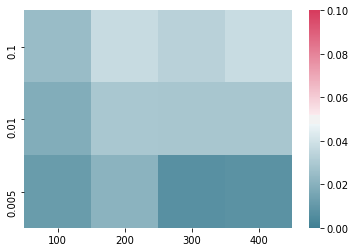

Y7.I.0 variance
            100       200       300       400
0.1    0.017829  0.023549  0.026340  0.023639
0.01   0.044407  0.022033  0.020725  0.020031
0.005  0.059881  0.038320  0.067601  0.058444


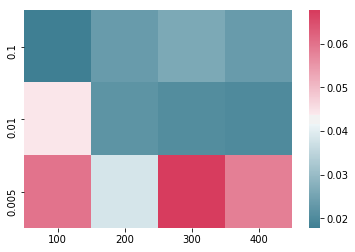

Y7.I.0 test
            100       200       300       400
0.1    0.585091  0.578364  0.579746  0.590206
0.01   0.505885  0.573090  0.583335  0.589222
0.005  0.369868  0.506993  0.537409  0.552723


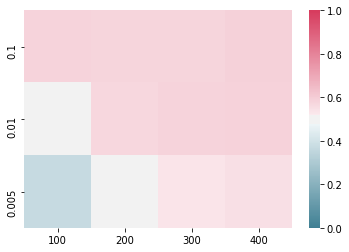

Y7.I.0 train
            100       200       300       400
0.1    0.999865  1.000000  1.000000  1.000000
0.01   0.778541  0.932473  0.974407  0.988860
0.005  0.548590  0.777670  0.892338  0.941105


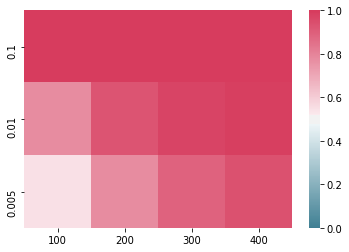

Y7.I.0 bcstd
            100       200       300       400
0.1    0.001078  0.001028  0.000585  0.002470
0.01   0.006459  0.002588  0.001342  0.002008
0.005  0.013673  0.008613  0.021516  0.020752


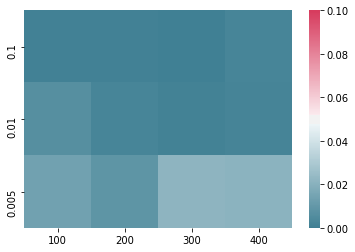

Y7.I.1 variance
            100       200       300       400
0.1    0.029437  0.028867  0.022383  0.030647
0.01   0.049173  0.030005  0.029309  0.025699
0.005  0.067339  0.045763  0.040103  0.038180


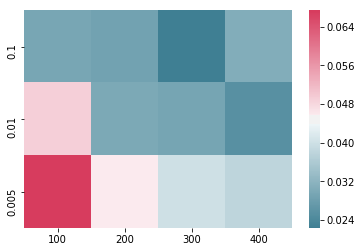

Y7.I.1 test
            100       200       300       400
0.1    0.487356  0.490239  0.491644  0.490118
0.01   0.435932  0.487755  0.493110  0.492463
0.005  0.320852  0.436128  0.458809  0.475574


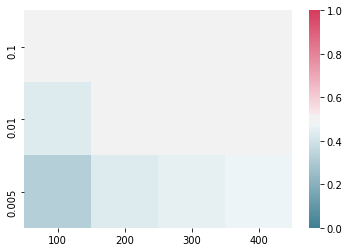

Y7.I.1 train
            100       200      300       400
0.1    0.999860  1.000000  1.00000  1.000000
0.01   0.768541  0.929192  0.97400  0.989395
0.005  0.535324  0.766918  0.87295  0.926999


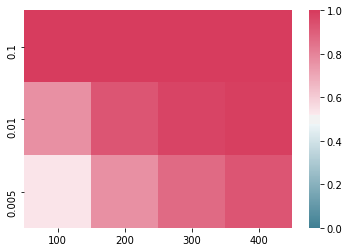

Y7.I.1 bcstd
            100       200       300       400
0.1    0.017258  0.017375  0.026364  0.023765
0.01   0.014094  0.020038  0.020284  0.022802
0.005  0.010719  0.013969  0.012738  0.013013


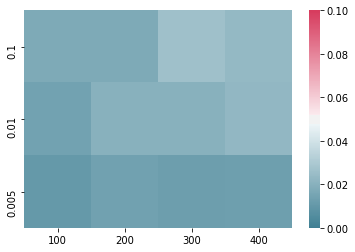

Y8.R.0 variance
            100       200       300       400
0.1    0.032485  0.041405  0.034932  0.028241
0.01   0.052321  0.040118  0.038350  0.037632
0.005  0.064199  0.052890  0.032231  0.027959


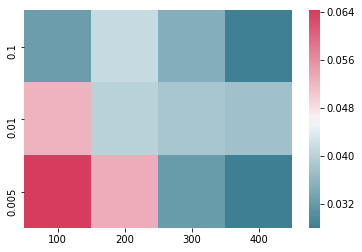

Y8.R.0 test
            100       200       300       400
0.1    0.500559  0.499869  0.490555  0.497012
0.01   0.436229  0.500648  0.509775  0.512595
0.005  0.318352  0.436346  0.452409  0.472638


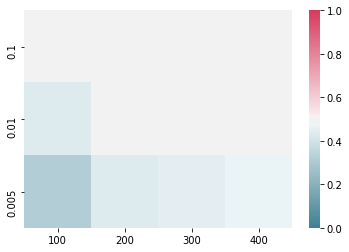

Y8.R.0 train
            100      200       300       400
0.1    0.999891  1.00000  1.000000  1.000000
0.01   0.767399  0.93104  0.974554  0.989393
0.005  0.532013  0.76720  0.870732  0.926904


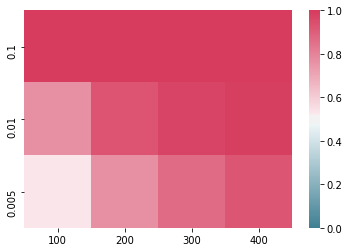

Y8.R.0 bcstd
            100       200       300       400
0.1    0.011943  0.021169  0.008215  0.017167
0.01   0.007664  0.012247  0.012864  0.012666
0.005  0.005496  0.007983  0.002127  0.003260


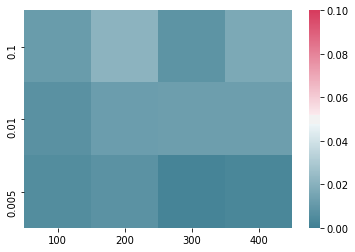

Y8.I.0 variance
            100       200       300       400
0.1    0.046328  0.033915  0.034325  0.037039
0.01   0.054878  0.038348  0.036041  0.034499
0.005  0.078047  0.055289  0.055200  0.047544


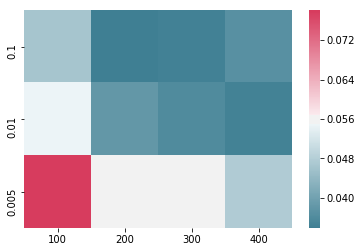

Y8.I.0 test
            100       200       300       400
0.1    0.463253  0.463081  0.466046  0.463232
0.01   0.411103  0.460462  0.468243  0.476370
0.005  0.299365  0.410444  0.449753  0.468927


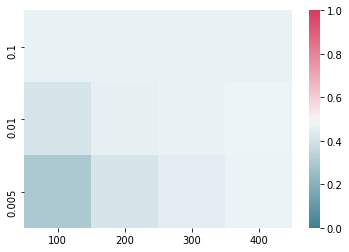

Y8.I.0 train
            100       200       300       400
0.1    0.999879  1.000000  1.000000  1.000000
0.01   0.762193  0.925872  0.972331  0.988270
0.005  0.529779  0.759658  0.866327  0.922099


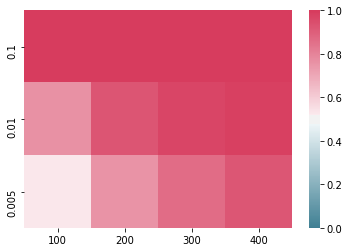

Y8.I.0 bcstd
            100       200       300       400
0.1    0.039503  0.023096  0.031892  0.033903
0.01   0.011391  0.018732  0.023101  0.025581
0.005  0.006238  0.012756  0.005174  0.003113


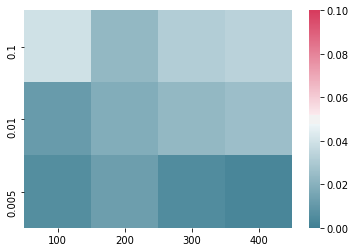

Y9.R.0 variance
            100       200       300       400
0.1    0.057129  0.054653  0.063766  0.064010
0.01   0.066331  0.043231  0.048076  0.051215
0.005  0.097344  0.063310  0.047592  0.045899


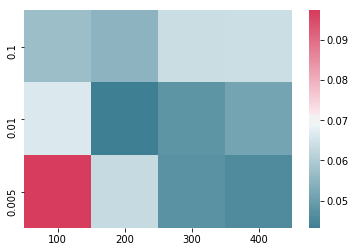

Y9.R.0 test
            100       200       300       400
0.1    0.438339  0.444056  0.445951  0.436951
0.01   0.399315  0.457105  0.459654  0.458445
0.005  0.294791  0.402158  0.451788  0.468026


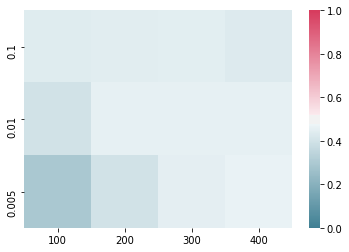

Y9.R.0 train
            100       200       300       400
0.1    0.999850  1.000000  1.000000  1.000000
0.01   0.763404  0.926635  0.972127  0.988049
0.005  0.534197  0.763386  0.866070  0.922240


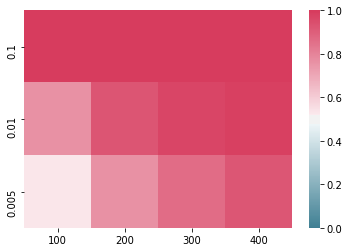

Y9.R.0 bcstd
            100       200       300       400
0.1    0.001345  0.007771  0.002094  0.004631
0.01   0.005937  0.000154  0.001430  0.000689
0.005  0.010840  0.004698  0.025976  0.023296


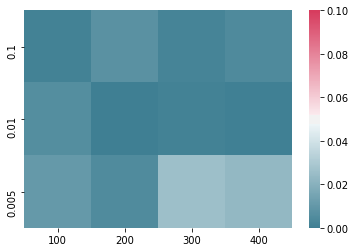

Y9.I.0 variance
            100       200       300       400
0.1    0.043308  0.040437  0.035233  0.041304
0.01   0.058370  0.041866  0.040918  0.039453
0.005  0.080807  0.060732  0.042247  0.036563


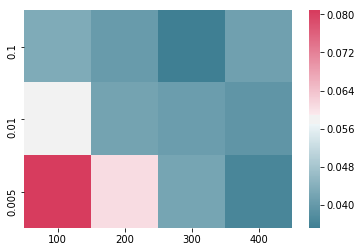

Y9.I.0 test
            100       200       300       400
0.1    0.457553  0.450463  0.453462  0.452528
0.01   0.390919  0.447190  0.456655  0.459085
0.005  0.284138  0.391554  0.470642  0.491458


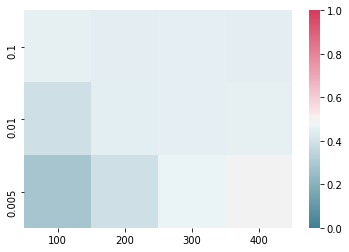

Y9.I.0 train
            100       200       300       400
0.1    0.999867  1.000000  1.000000  1.000000
0.01   0.749977  0.918607  0.968823  0.987084
0.005  0.518263  0.748634  0.861678  0.917244


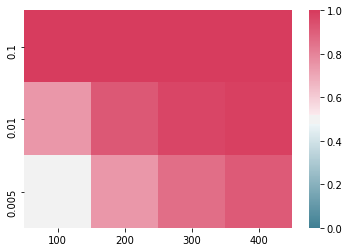

Y9.I.0 bcstd
            100       200       300       400
0.1    0.001450  0.004398  0.004689  0.005676
0.01   0.000744  0.000346  0.001971  0.000938
0.005  0.004306  0.000281  0.027234  0.031029


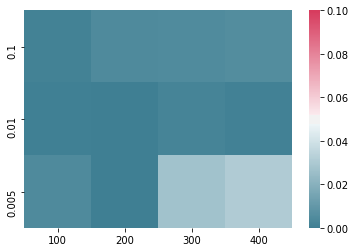

In [20]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as plot
import seaborn as sbn
import re
import math
from itertools import product

# maximum number of channels
chmax = 1

#idate = [ '06192019.0{:2d}'.format(i) for i in range(18, 30)]#'0530', '0531' ]#, '0525' ]
#idate = ['06272019.0{:2d}'.format(i) for i in range(20)]
idate = [ '06192019']
# return scores and its deviations from each output file
def read(file): 
    scr = {}
    err = {}
    scr0 = {}
    bs = {}
    with open(file, 'r') as pf:
        m = 0
        stl = None
        cont = False
        for line in pf:
            if 'unlbl' in line:
                unlbl = int(line.split()[-2].split('/')[-1])
            if re.search('Y\d\.(R|I)', line) is not None:
                #print(line)
                nf = line.split()
                try:
                    bs[nf[0]].append(math.sqrt((float(nf[6])-float(nf[1]))**2/float(nf[-7])**2/float(unlbl)))
                    scr[nf[0]].append(float(nf[-3])+bs[nf[0]][-1]**2)#+bs[-1]**2/float(nf[-4]))/float(stl[m]))
                    err[nf[0]].append(abs(float(nf[-1])/float(stl[m])))
                    scr0[nf[0]].append(stl[m])
                except:
                    bs[nf[0]] = [math.sqrt((float(nf[6])-float(nf[1]))**2/(float(nf[-7]))**2/float(unlbl))]
                    scr[nf[0]] = [float(nf[-3])+bs[nf[0]][-1]**2]#+bs[-1]**2/float(nf[-4]))/float(stl[m])]
                    err[nf[0]] = [abs(float(nf[-1])/float(stl[m]))]
                    scr0[nf[0]] = [stl[m]]
                m += 1
            l = line.split()
            try:
                if l[0] == 'score':
                    stl = line.split('[')[1].split(']')[0].split()
                    m = 0
                    if ']' in line:
                        cont = False
                    else:
                        cont = True
                elif cont:
                    stl.extend(line.split(']')[0].split())
                    if ']' in line:
                        cont = False
            except:
                pass
        #print(err)
        pf.close()
    return scr, err, scr0, bs

tabtemp = pds.DataFrame(dtype=float)#, columns=['100', '200', '300', '400'], index=[ '1', '0.5', '0.2', '0.1', '0.01', '0.005', '0.001', '0.0005', '0.0001' ])

def make_table(par, file, ofile):
    tab = {}
    tabv = {}
    tab0 = {}
    tabbss = {}
    n=0
    print("file length is {:}".format(len(file)))
    for j in par:
        for i in par[j]:
            #print(n)
            scrl, errl, scr0l, bs = read(file[n])
            l=0
            for erk in errl:
                m=0
                for err in errl[erk]:
                    #print("err is ", err)
                    if erk+'.'+str(m) in tab:
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    else:
                        tab[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    m+=1
            n+=1
    pf = open(ofile, 'a+')
    m = 0
    try:
        os.mkdir(ofile+'.plot')
    except:
        print("Warning: directory "+ofile+".plot/ already exists!")
    for key in tab:
        fig, ax = mplot.subplots()
        print(key+" variance")
        print(tab[key])
        ax = sbn.heatmap(tab[key], cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pvar.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" test")
        print(tabv[key])
        ax = sbn.heatmap(tabv[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptst.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" train")
        print(tab0[key])
        ax = sbn.heatmap(tab0[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptrn.'+str(m)+'.pdf', format='pdf')
        #pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\n".format(tab[key], tabv[key], tab0[key]))
        fig, ax = mplot.subplots()
        print(key+" bcstd")
        print(tabbss[key])
        ax = sbn.heatmap(tabbss[key], vmin=0.0, vmax=0.1, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pbcstd.'+str(m)+'.pdf', format='pdf')
        pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\nbcstd \n {:} \n\n".format(tab[key], tabv[key], tab0[key], tabbss[key]))
        m += 1
    pf.close()
    del tab
    del tabv
    del tab0
    del tabbss
    return

odir = '/Users/ruizi/Documents/ML/outputs/pdf/meson/ave/0619p'

params = {}
for i, j in product([0.5, 0.1, 0.01, 0.005, 0.001], [100, 200, 300, 400]):#[ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):# [ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005 ], [100, 200, 300, 400]):
#for i, j in product([50,10,5], [100])
    try:
        params[str(i)].append(str(j))
    except:
        params[str(i)] = [str(j)]
        
for ch in range(chmax):
    files = []
    for d1, d2, f in os.walk(odir): 
        #print(d1)
        for ddir in d2:
            for dt in idate:
                if dt in ddir:
                    files.append(odir+'/'+ddir+'/CV1.'+str(ch)) 
        break
    files.sort()
    print("channel {:}".format(ch))
    make_table(params, files, odir+'/score.ch'+str(ch))        

In [ ]:
import numpy

numpy.random.seed(2019)
print("{:}".format(numpy.random.randint(0,50,10)))
print("{:}".format(numpy.random.randint(0,50,10)))

a=numpy.array([[1,2], [3,4], [5,6]])
print(a.mean(axis=1))
print(abs(a))
a=[[1,2], [3,4], [5,6]]
print(a[0:1])
print(['ML.06122019.0{:02d}'.format(i) for i in range(3, 13) ])

In [ ]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as plot
import seaborn as sbn
import re
import math
from itertools import product

idir='/Users/ruizi/Documents/ML/outputs/pdf/'
dirjk = ['ML.06112019.006', 'ML.06112019.014']
key = ['50', '40']
dirbs = ['ML.06122019.0{:02d}'.format(i) for i in range(3, 13) ]
odir = '/Users/ruizi/Documents/ML/outputs/pdf/plots'
p = [ 5, 7 ]
trn = [ 50, 40 ]
q=0
for ch in [ '0', '2' ]:
    errl = {}
    ratiol = {}
    m = 0
    for d in dirjk:
        file = idir+d+'/JK.'+ch
        flag = 0
        tmpe = {}
        tmpr = {}
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            tmpe[nn[3]] = [float(nn[-1])]
                            tmpr[nn[3]] = [float(nn[4])]
            pf.close()
        errl[key[m]] = tmpe
        ratiol[key[m]] = tmpr
        m += 1
    m = 0
    for d in dirbs:
        file = idir+d+'/BS.'+ch
        flag = 0
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            errl[key[m]][nn[3]].append(float(nn[-1]))
                            ratiol[key[m]][nn[3]].append(float(nn[4]))
                            print("BS: adding data at trn {:} t {:}".format(key[m], nn[3]))
            pf.close()
        m += 1
        if m == len(key):
            m = 0
    m = 0
    for k in key:
        for T in ratiol[k]:
            l = len(ratiol[k][T])
            r = [ratiol[k][T][0]]
            e = [errl[k][T][0]]
            r.extend(ratiol[k][T][m+1::len(key)])
            e.extend(errl[k][T][m+1::len(key)])
            fig, ax = mplot.subplots()
            print('Y = {:} err={:}'.format(r, e))
            ax.errorbar([0, 100, 110, 200, 210, 220], ratiol[k][T], yerr=errl[k][T], barsabove=True, fmt='o', capthick=10)
            ax.set_title('Ratio: P = {:} trn = {:} t = {:}'.format(p[q], k, T))
            mplot.show()
            fig.savefig(odir+'/P{:}tn{:}t{:}.pdf'.format(p[q], k, T), format='pdf')
        m += 1
    q += 1